In [1]:
import torch
import random
import subprocess
import numpy as np
from tqdm import tqdm
from scipy import stats
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib
import os

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [4]:
def autolabel(rects, fontsize = 27):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize = fontsize)

In [5]:
def adata2numpy(adata):
    if sparse.issparse(adata.X):
        return adata.X.A
    else:
        return adata.X

In [6]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375, data_name = 'pbmc'):
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=25)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(16, 12))
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
        plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    plt.title(f"{data_name}_bar_plot", fontsize=40)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=30)
    plt.xticks(x_pos+offset, u, rotation=90)
    plt.grid(False)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join('figures/bar_plot', filename), dpi=300)
    plt.show()

In [7]:
def calc_R2_specific_model(adata, n_genes, conditions):
    if n_genes != adata.shape[1]:
        sc.tl.rank_genes_groups(adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    r2_means, r2_vars = [], []
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    pred_stim = adata2numpy(pred_stim)
    real_stim = adata2numpy(real_stim)

    x = np.asarray(np.mean(pred_stim, axis=0)).ravel()
    y = np.asarray(np.mean(real_stim, axis=0)).ravel()
    m, b, r_value, p_value, std_err = stats.linregress(x, y)
#     print("rvalue:", r_value)
    r_values = r_value ** 2
#     print(r_values.mean(), r_values.std())
    return r_values.mean(), r_values.std()

In [8]:
names = {
    "pbmc": ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK'],
    "hpoly": ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'Goblet', 'Stem', 'TA', 'TA.Early','Tuft'],
    "study": ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK'],
}
keys = {
    "pbmc": ['stimulated', 'control', 'pred', 'cell_type'],
    "hpoly": ['Hpoly.Day10', 'Control', 'pred', 'cell_label'],
    "study": ['stimulated', 'control', 'pred', 'cell_type'],
}

In [9]:
scperb_all_data = {
    "pbmc": sc.read("scperb_pbmc_all_data.h5ad"),
    "hpoly": sc.read("scperb_hpoly_all_data.h5ad"),
    "study": sc.read("scperb_study_all_data.h5ad"),
}

scgen_all_data = {
    "pbmc": sc.read("scgen_pbmc_all_data.h5ad"),
    "hpoly": sc.read("scgen_hpoly_all_data.h5ad"),
    "study": sc.read("scgen_study_all_data.h5ad"),
}

CVAE_all_data = {
    "pbmc": sc.read("CVAE_pbmc_all_data.h5ad"),
    "hpoly": sc.read("CVAE_hpoly_all_data.h5ad"),
    "study": sc.read("CVAE_study_all_data.h5ad"),
}

STGAN_all_data = {
    "pbmc": sc.read("STGAN_pbmc_all_data.h5ad"),
    "hpoly": sc.read("STGAN_hpoly_all_data.h5ad"),
    "study": sc.read("STGAN_study_all_data.h5ad"),
}

WGAN_all_data = {
    "pbmc": sc.read("WGAN_pbmc_all_data.h5ad"),
    "hpoly": sc.read("WGAN_hpoly_all_data.h5ad"),
    "study": sc.read("WGAN_study_all_data.h5ad"),
}

# scperb_pbmc_all_data = sc.read("data/scperb_pbmc_all_data.h5ad")
# scgen_pbmc_all_data = sc.read("data/scgen_pbmc_all_data.h5ad")
# CVAE_pbmc_all_data = sc.read("data/CVAE_pbmc_all_data.h5ad")
# STGAN_pbmc_all_data = sc.read("data/STGAN_pbmc_all_data.h5ad")
# WGAN_pbmc_all_data = sc.read("data/WGAN_pbmc_all_data.h5ad") 

# scperb_hpoly_all_data = sc.read("data/scperb_hpoly_all_data.h5ad")
# scgen_hpoly_all_data = sc.read("data/scgen_hpoly_all_data.h5ad")
# CVAE_hpoly_all_data = sc.read("data/CVAE_hpoly_all_data.h5ad")
# STGAN_hpoly_all_data = sc.read("data/STGAN_hpoly_all_data.h5ad")
# WGAN_hpoly_all_data = sc.read("data/WGAN_hpoly_all_data.h5ad")

# scperb_study_all_data = sc.read("data/scperb_study_all_data.h5ad")
# scgen_study_all_data = sc.read("data/scgen_study_all_data.h5ad")
# CVAE_study_all_data = sc.read("data/CVAE_study_all_data.h5ad")
# STGAN_study_all_data = sc.read("data/STGAN_study_all_data.h5ad")
# WGAN_study_all_data = sc.read("data/WGAN_study_all_data.h5ad")

valid = {
    "pbmc": sc.read("../data/valid_pbmc.h5ad"),
    "hpoly": sc.read("../data/valid_hpoly.h5ad"),
    "study": sc.read("../data/valid_study.h5ad"),
}

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/__init__.py:

In [10]:
def get_cell_type_data(cell_type, name):
    ctrl = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][1])]
    stim = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][0])]
    scperb_pred = scperb_all_data[name][(scperb_all_data[name].obs[keys[name][3]] == cell_type) & (scperb_all_data[name].obs['condition'] == "pred")]
    scgen_pred = scgen_all_data[name][(scgen_all_data[name].obs[keys[name][3]] == cell_type) & (scgen_all_data[name].obs['condition'] == "pred")]
    CVAE_pred = CVAE_all_data[name][(CVAE_all_data[name].obs[keys[name][3]] == cell_type) & (CVAE_all_data[name].obs['condition'] == "pred")]
    STGAN_pred = STGAN_all_data[name][(STGAN_all_data[name].obs[keys[name][3]] == cell_type) & (STGAN_all_data[name].obs['condition'] == "pred")]
    WGAN_pred = WGAN_all_data[name][(WGAN_all_data[name].obs[keys[name][3]] == cell_type) & (WGAN_all_data[name].obs['condition'] == "pred")]
    scperb_pred.obs['condition'] = "scperb"
    scgen_pred.obs['condition'] = "scgen"
    CVAE_pred.obs['condition'] = "CVAE"
    STGAN_pred.obs['condition'] = "STGAN"
    WGAN_pred.obs['condition'] = "sc-WGAN"
    ctrl.obs['condition'] = "control"
    stim.obs['condition'] = "real"
    all_data = ctrl.concatenate(stim, scperb_pred, scgen_pred, CVAE_pred, STGAN_pred, WGAN_pred)
    return all_data

In [11]:
def make_df(all_means, all_vars, cell_type, name):
    all_types = ["All genes"] * 5
    models = ["scperb", "scgen", "CVAE", "STGAN", "sc-WGAN", ]
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Models": models, "cell": cell_type, "dataset": name})
    return df

In [12]:
def get_cell_type_df(cell_type, name):
    ctrl = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][1])]
    stim = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][0])]
    
    scperb_pred = scperb_all_data[name][(scperb_all_data[name].obs[keys[name][3]] == cell_type)]
    scgen_pred = scgen_all_data[name][(scgen_all_data[name].obs[keys[name][3]] == cell_type)]
    CVAE_pred = CVAE_all_data[name][(CVAE_all_data[name].obs[keys[name][3]] == cell_type)]
    STGAN_pred = STGAN_all_data[name][(STGAN_all_data[name].obs[keys[name][3]] == cell_type)]
    WGAN_pred = WGAN_all_data[name][(WGAN_all_data[name].obs[keys[name][3]] == cell_type)]
    
#     scperb_pred.obs['condition'] = "scperb"
#     scgen_pred.obs['condition'] = "scgen"
#     CVAE_pred.obs['condition'] = "CVAE"
#     STGAN_pred.obs['condition'] = "STGAN"
#     WGAN_pred.obs['condition'] = "WGAN"
    
    conditions = {"real_stim": keys[name][0], "pred_stim": "pred"}
    CVAE_r2_mean, CVAE_r2_var = calc_R2_specific_model(CVAE_pred, n_genes=6998, conditions=conditions)
    WGAN_r2_mean, WGAN_r2_var = calc_R2_specific_model(WGAN_pred, n_genes=6998, conditions=conditions)
    STGAN_r2_mean, STGAN_r2_var = calc_R2_specific_model(STGAN_pred, n_genes=6998, conditions=conditions)
    scgen_r2_mean, scgen_r2_var = calc_R2_specific_model(scgen_pred, n_genes=6998, conditions=conditions)
    scperb_r2_mean, scperb_r2_var = calc_R2_specific_model(scperb_pred, n_genes=6998, conditions=conditions)
    
    all_means = np.array([scperb_r2_mean, scgen_r2_mean, CVAE_r2_mean, STGAN_r2_mean, WGAN_r2_mean])
    all_vars = np.array([scperb_r2_var, scgen_r2_var, CVAE_r2_var, STGAN_r2_var, WGAN_r2_var])
#     all_types = ["All genes"] * 5
#     models = ["scperb", "scgen", "CVAE", "STGAN", "sc-WGAN", ]
#     df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Models": models})
    df = make_df(all_means, all_vars, cell_type, name)
    return df

In [13]:
def plot_bar(cell_type, name):
    font = {'family' : 'Arial',
        'size'   : 10}
    df = get_cell_type_df(cell_type, name)
#     print(df)
    matplotlib.rc('font', **font)
    matplotlib.rc('ytick', labelsize=20)
    matplotlib.rc('xtick', labelsize=20)
    grouped_barplot(df, "Models", "Type", "R^2 Means", "R^2 Stddevs", put_label=True, legend=False, filename=f"{name}_{cell_type}_models_barplots.pdf", offset=0.0, data_name = f'{name}_{cell_type}')
    return df

In [14]:
def grouped_allcelltype_barplot(df, cat, subcat, val, err, filename, put_label=True, legend=True, offset=50, data_name = 'pbmc', length = 35, ppt = False):
    colors = ['#DB3124', '#FC8C5A', '#FFDF92', '#90BEE0', '#8EB69C']
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=25)
    u = df[cat].unique()
    x_pos = np.arange(0, 5*len(u), 5)
    subx = df[subcat].unique()
    plt.figure(figsize=(16, 12))
    ax = plt.gca()
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
#         ax.text(x_popreds + i/1.25, dfg[val].values, f"{dfg[val].values}")
        b = ax.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values, color = colors[i])
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
#         ax.text(x_pos + i/1.25, dfg[val].values, f"{dfg[val].values}")
#         ax.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    if not ppt:
        plt.title(f"{data_name}_grouped_boxplot", fontsize=40)
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=30)
#     plt.xticks(x_pos + offset, u, rotation=90)
    plt.xticks(x_pos + offset, u)
    ax.set_facecolor('white')
    ax.axis(True)
    ax.grid(False)
    ax.spines["left"].set_color("k")
#     ax.spines["top"].set_color("k")
    ax.spines["bottom"].set_color("k")
#     ax.spines["right"].set_color("k")
    if legend:
        plt.legend(loc = 'best', prop={'size': 18})
    plt.tight_layout()
    plt.savefig(os.path.join('figures','grouped_boxplot', filename), transparent=True, dpi=300)
    print("saved at:" + os.path.join('figures','grouped_boxplot', filename))
    plt.show()

In [15]:
def plot_all_cell_type_bar_garph(name):
    df_all = pd.DataFrame()
    for cell_type in names[name]:
        df_now = plot_bar(cell_type, name)
        df_all = pd.concat([df_now, df_all])
#     print(df_all)
    grouped_allcelltype_barplot(df_all, 'cell', 'Models', 'R^2 Means', 'R^2 Stddevs', put_label=True, legend=False, filename=f"{name}_all_models_all_celltype_barplots.pdf", offset=0.0, data_name=f'{name}_all')
    df_all_saved = df_all
    
    all_mean = df_all.groupby(df_all.index)['R^2 Means'].sum().to_numpy()
    all_var = df_all.groupby(df_all.index)['R^2 Stddevs'].sum().to_numpy()
    
    for idx, value in enumerate(all_mean):
        all_mean[idx] = value / len(names[name])
        
    for idx, value in enumerate(all_var):
        all_var[idx] = value / len(names[name])
    
    df_all = make_df(all_mean, all_var, 'all', name)
    grouped_barplot(df_all, "Models", "Type", "R^2 Means", "R^2 Stddevs", put_label=True, legend=False, filename=f"{name}_all_models_barplots.pdf", offset=0.0, data_name = f'{name}_all')
    return [df_all, df_all_saved]

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

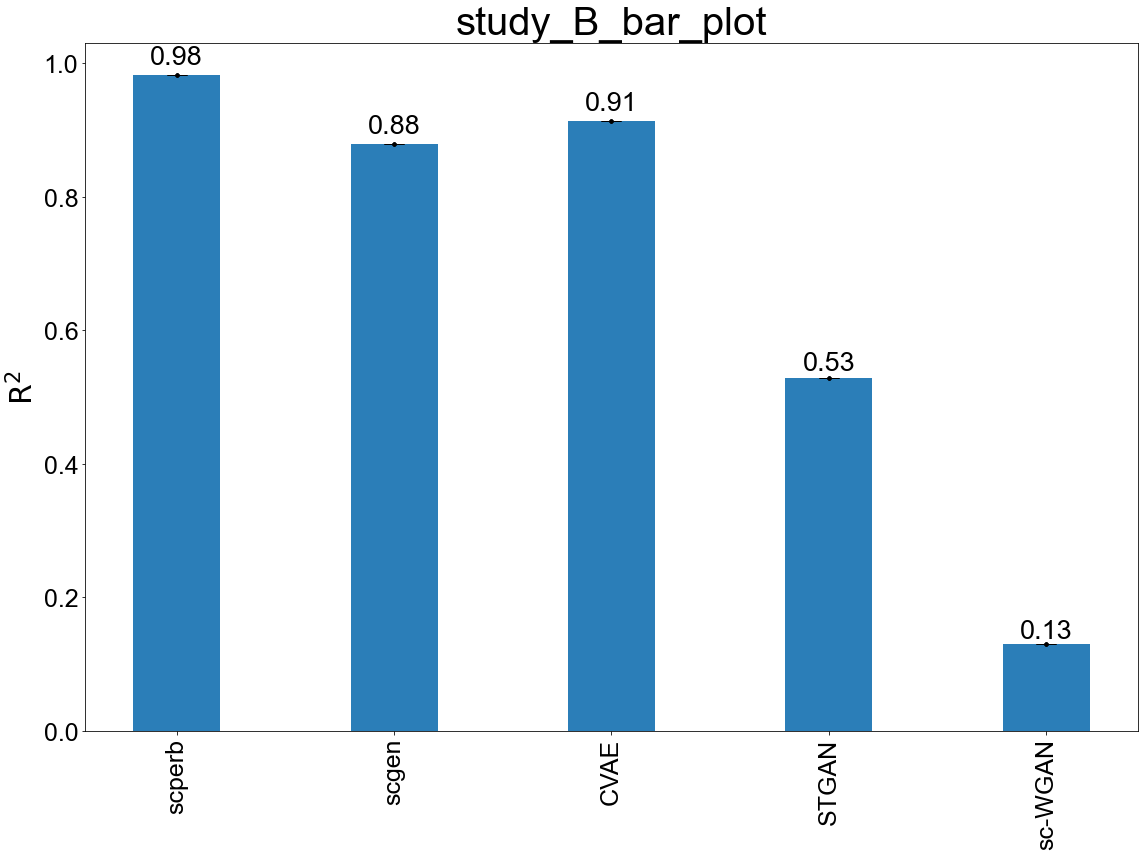

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

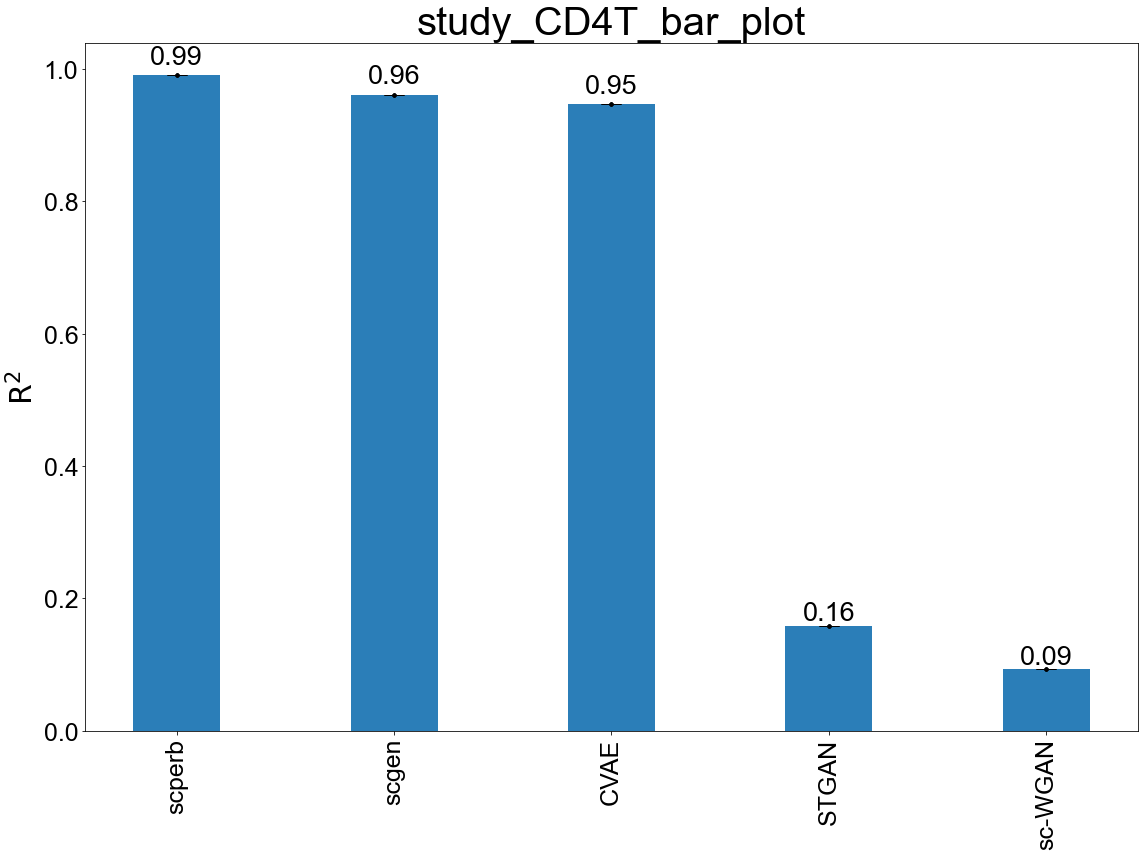

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

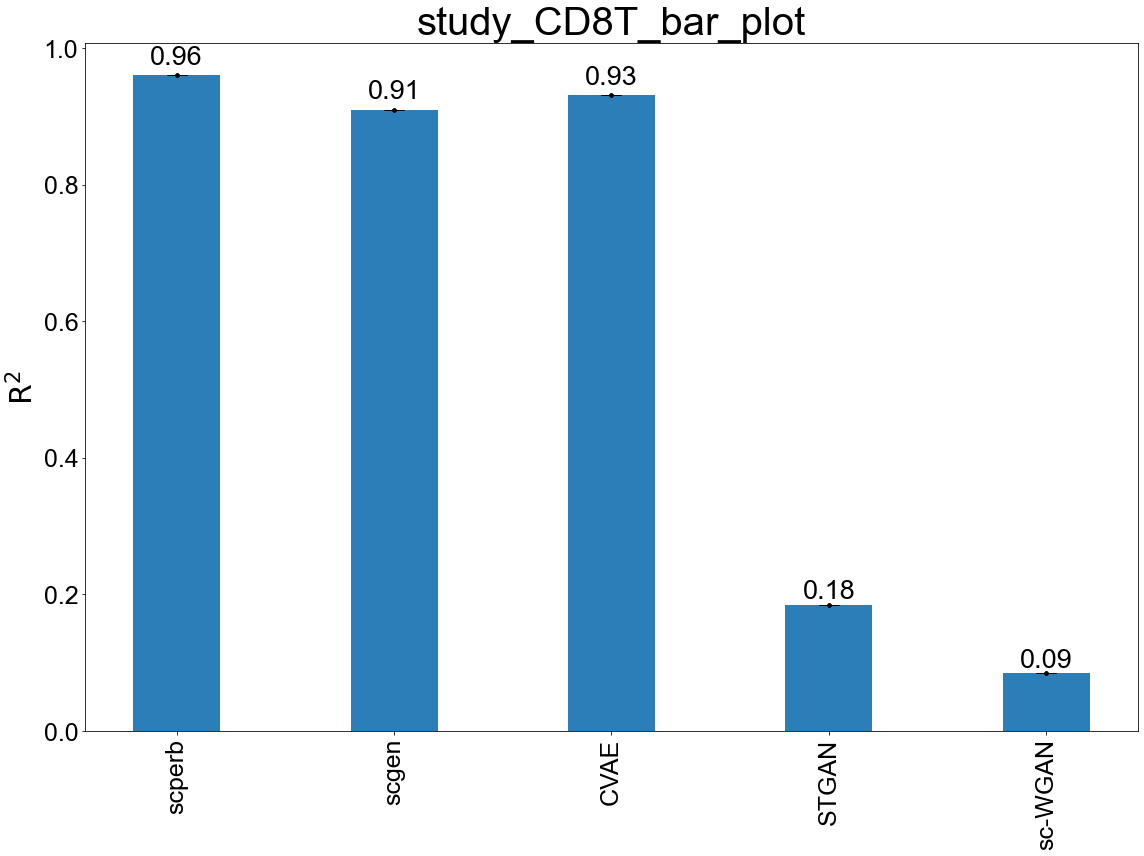

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

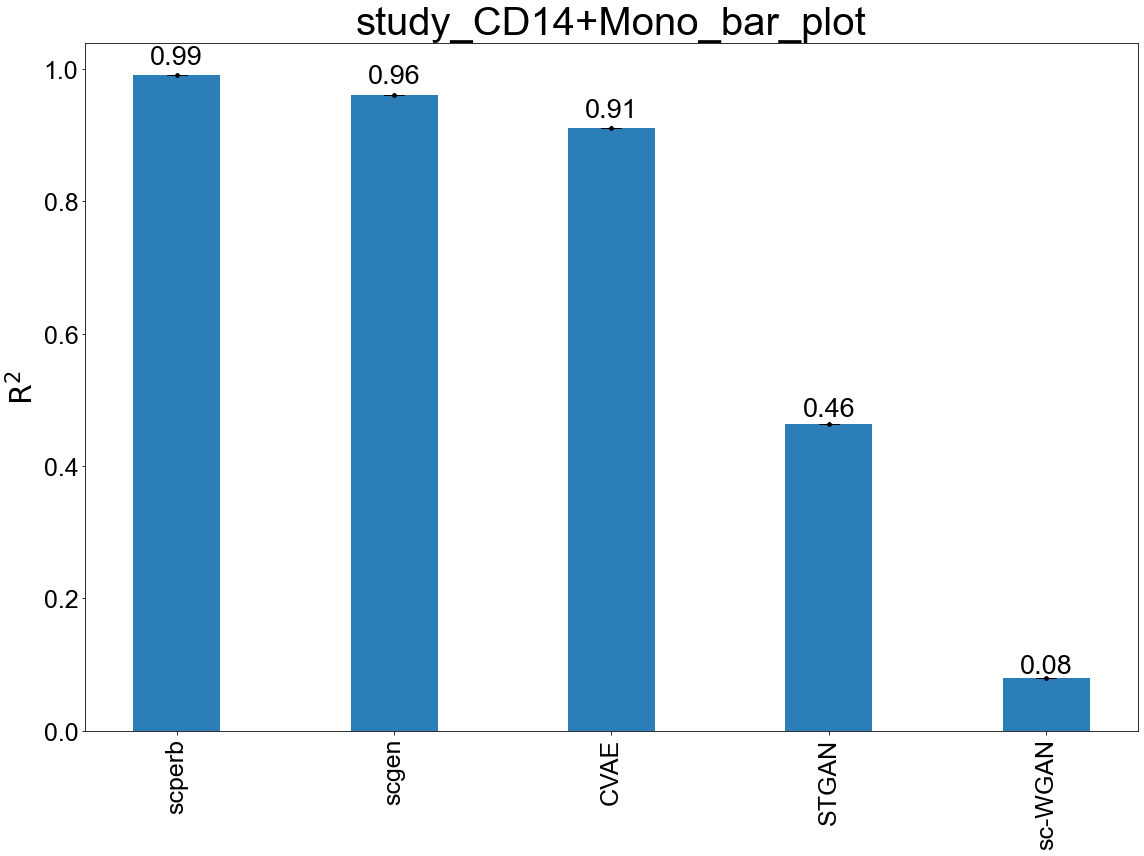

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

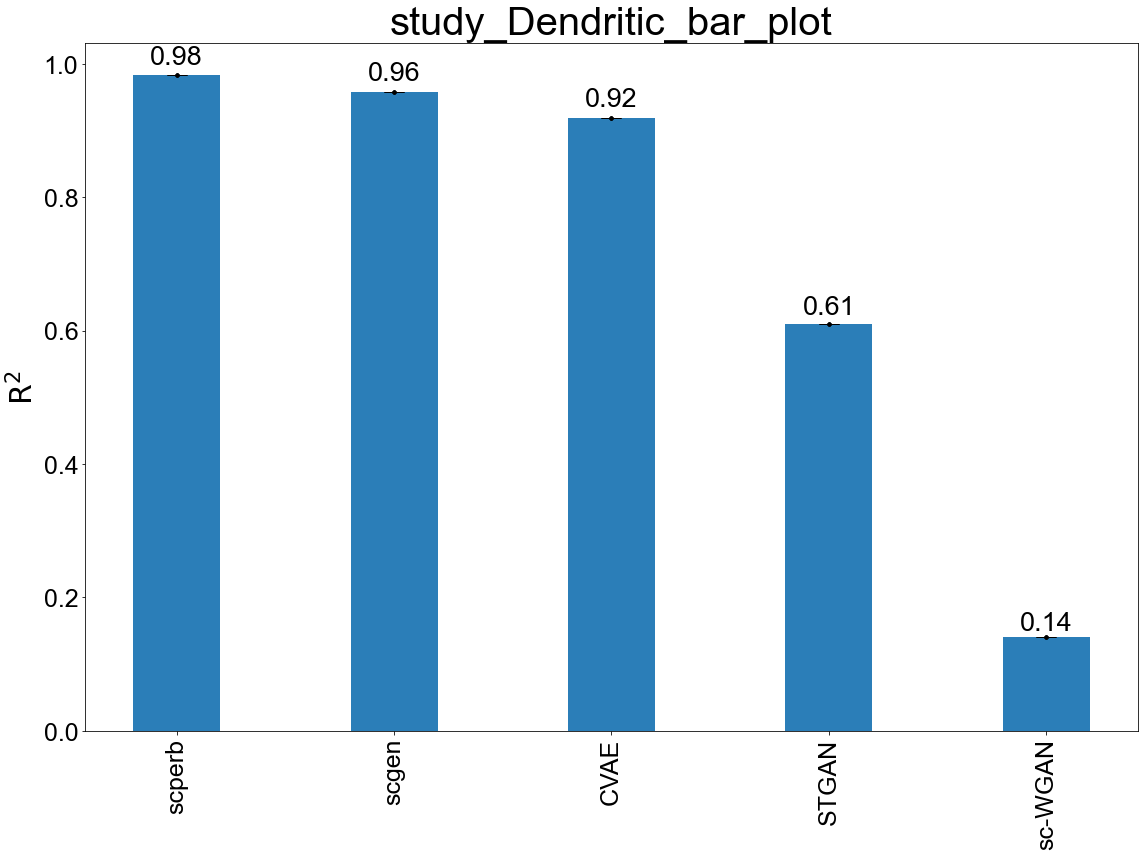

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

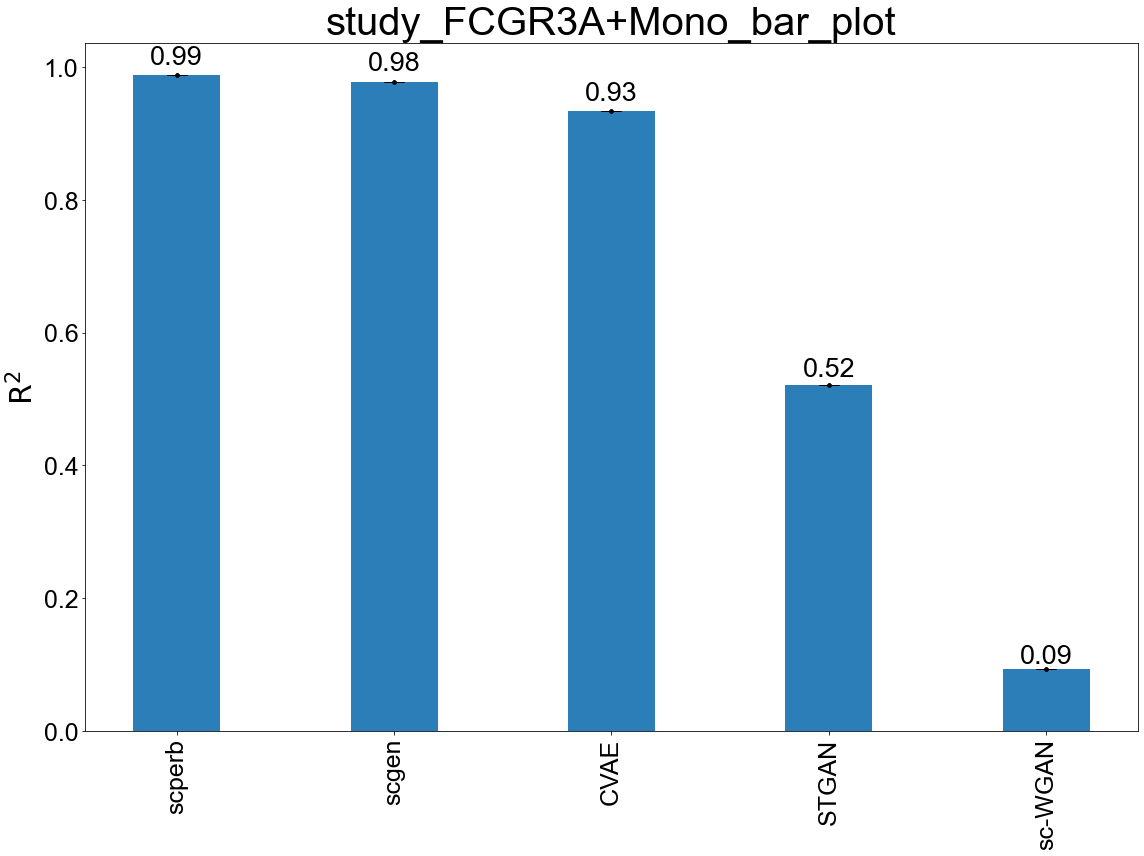

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

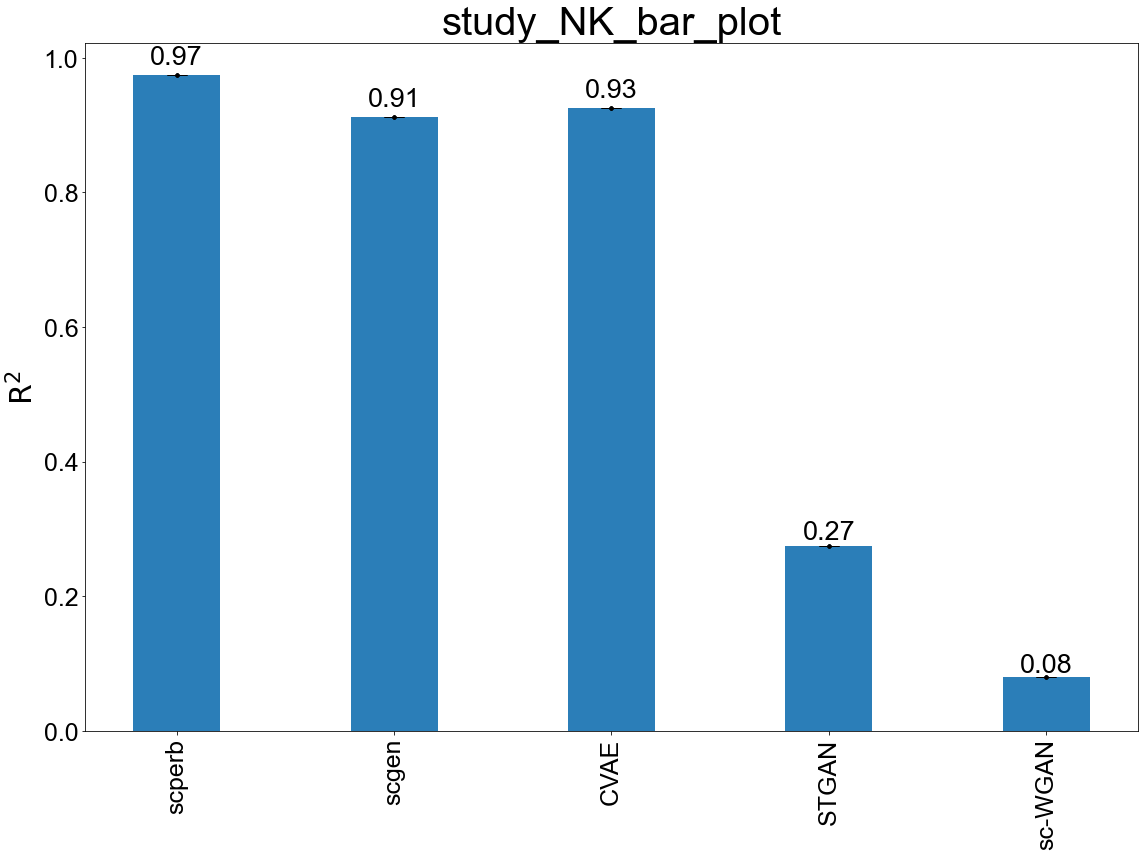

saved at:figures/grouped_boxplot/study_all_models_all_celltype_barplots.pdf


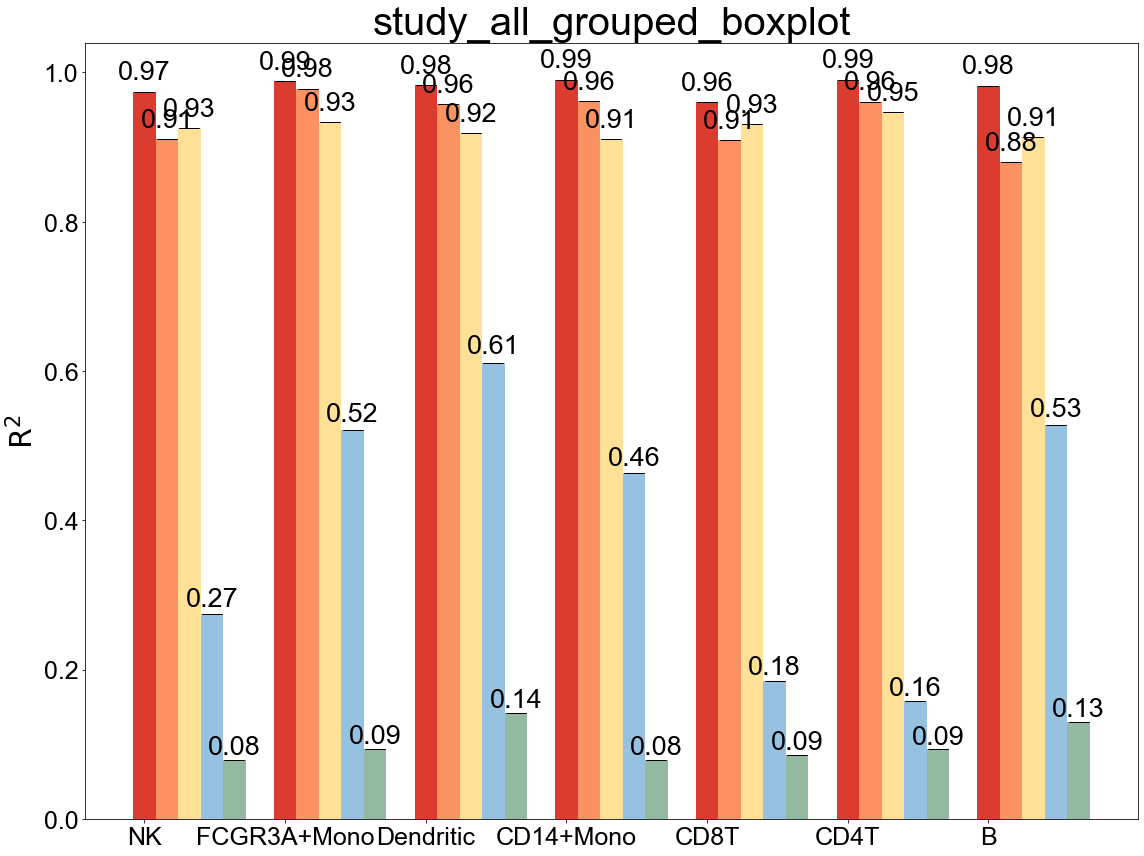

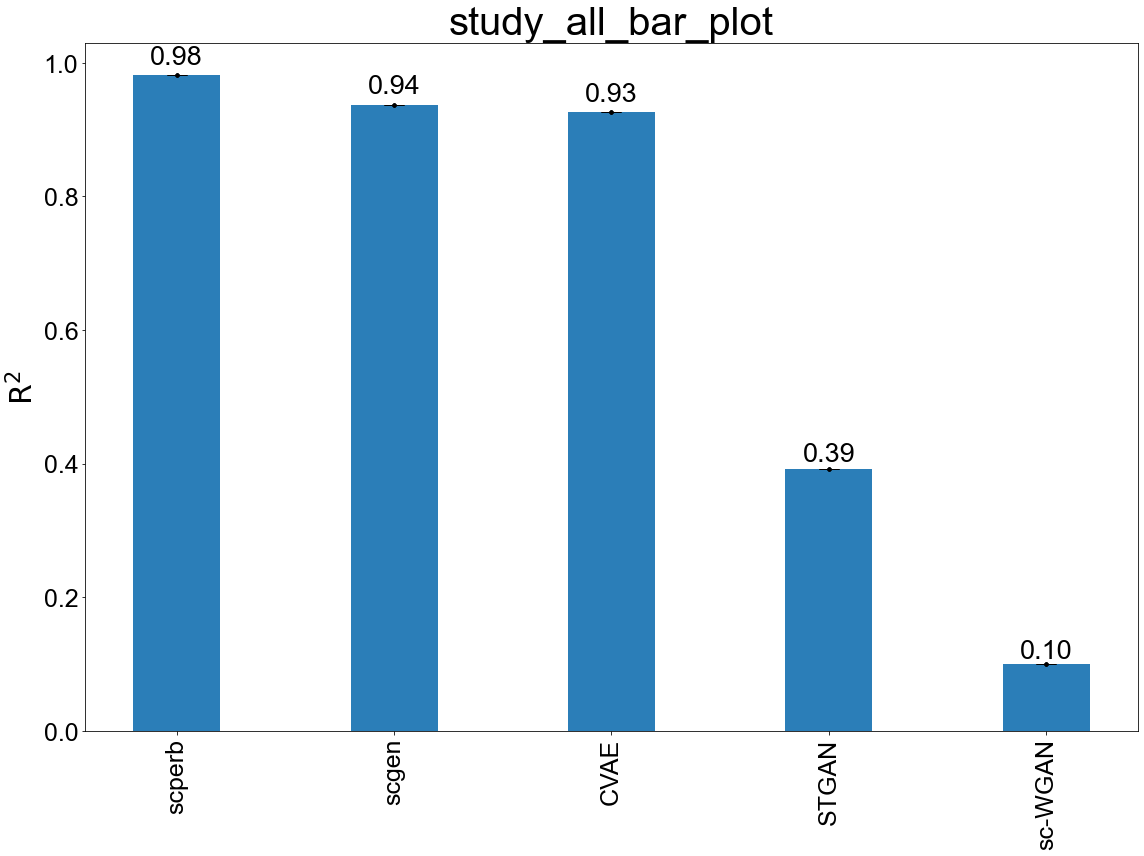

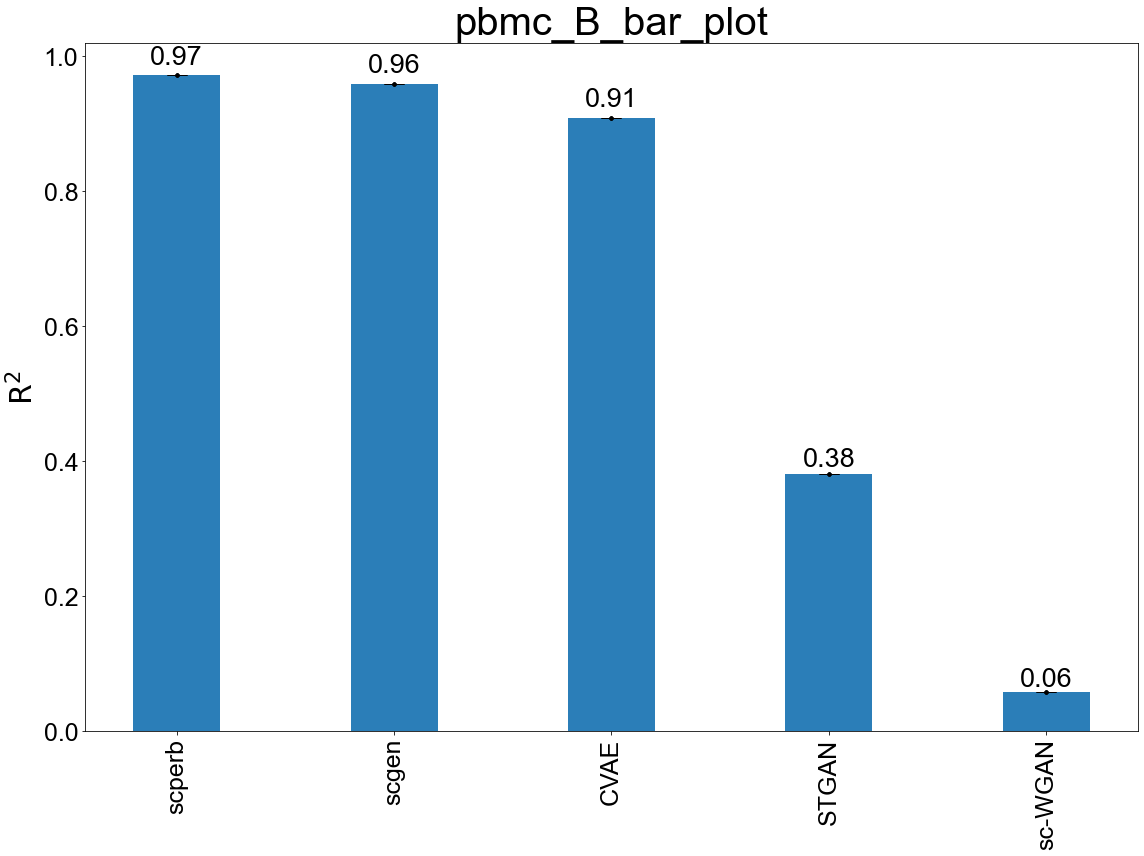

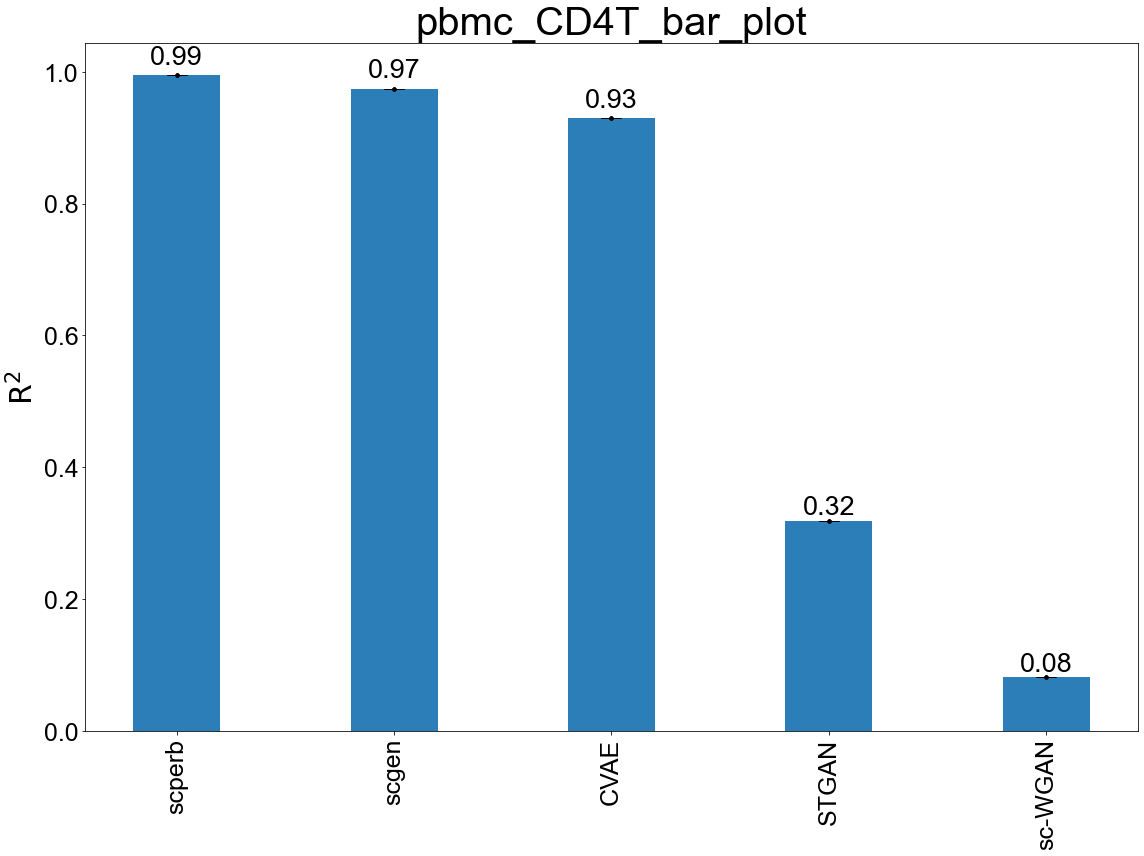

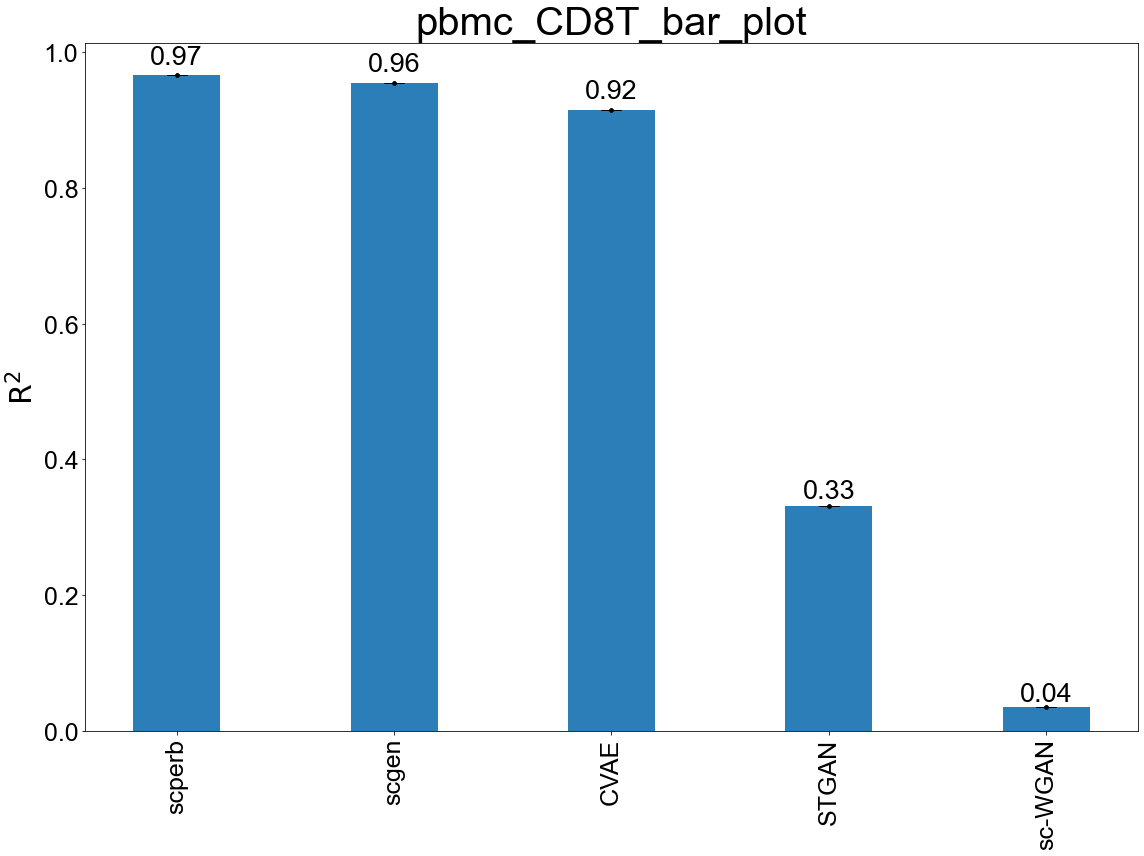

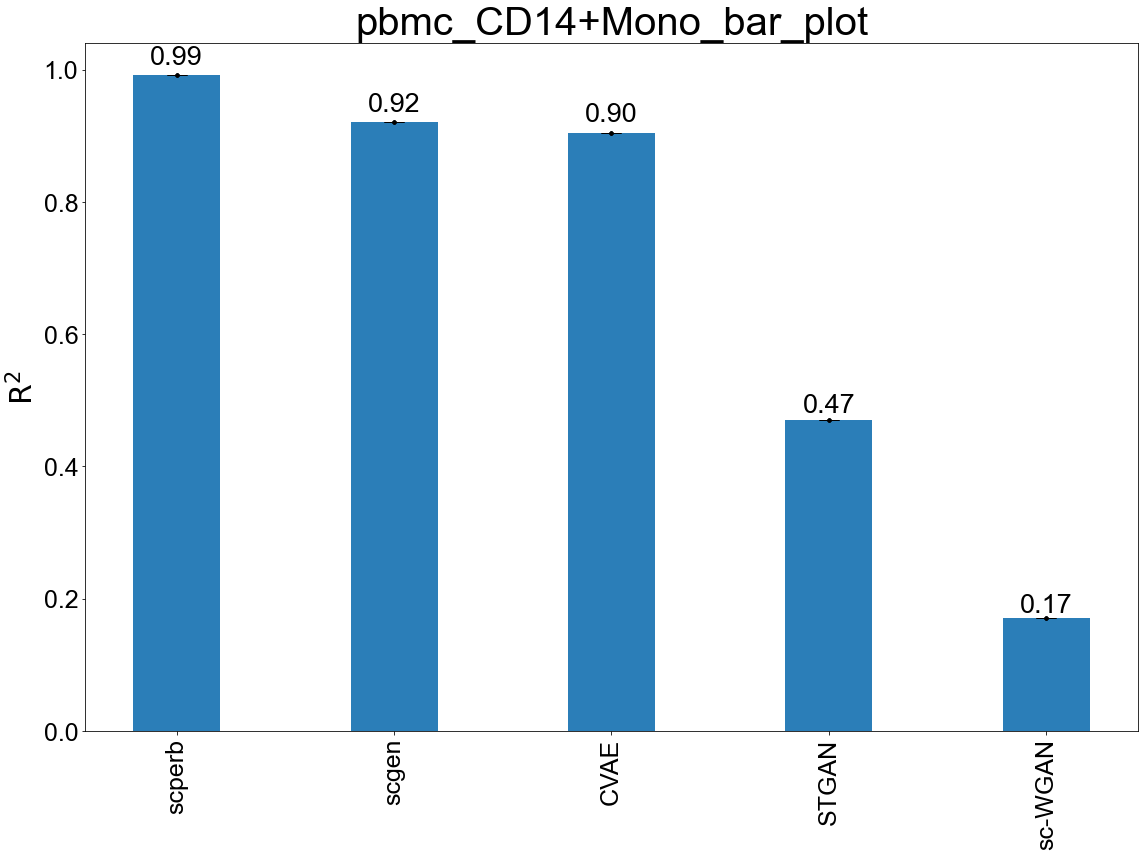

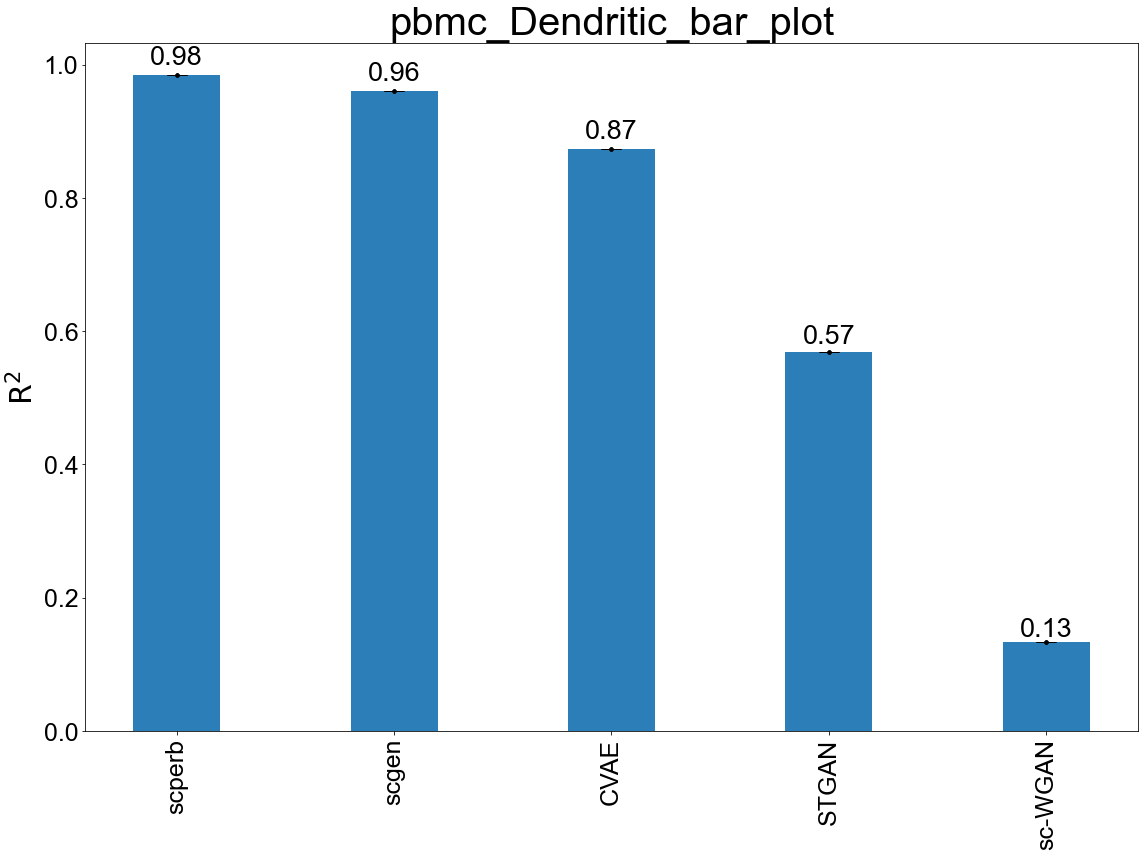

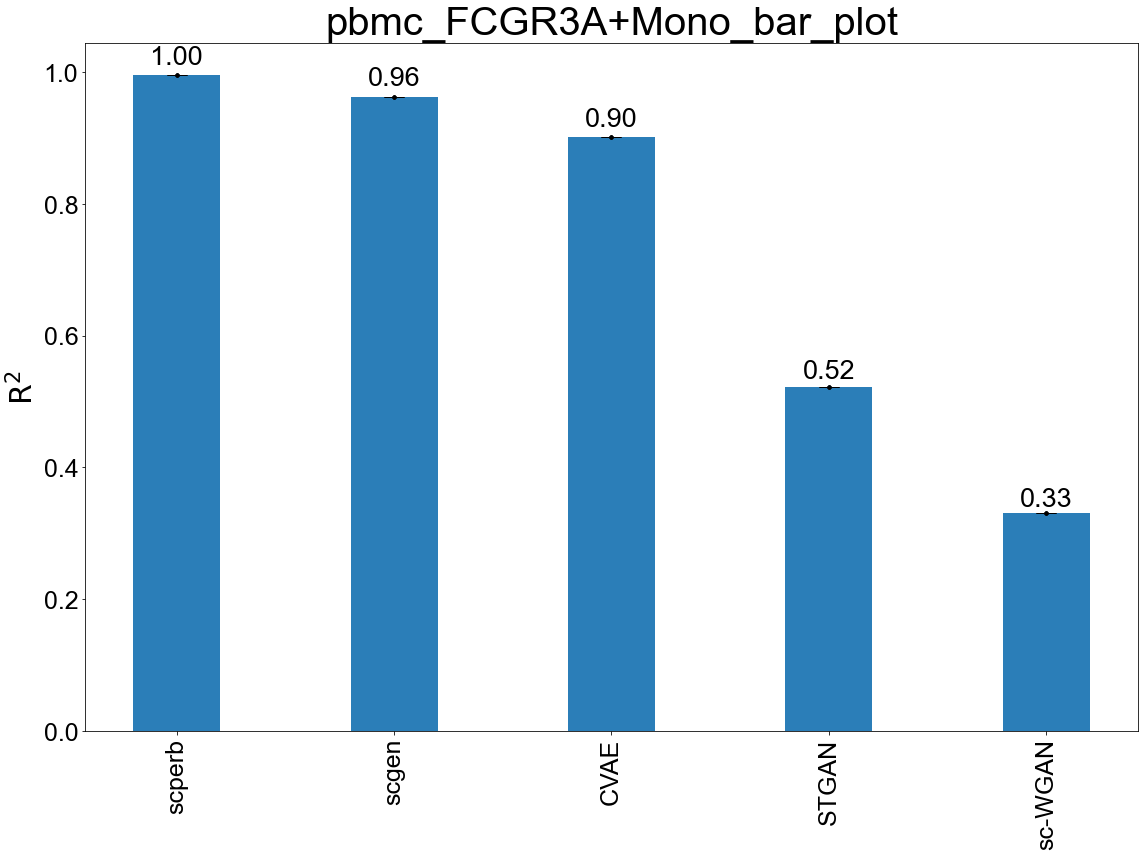

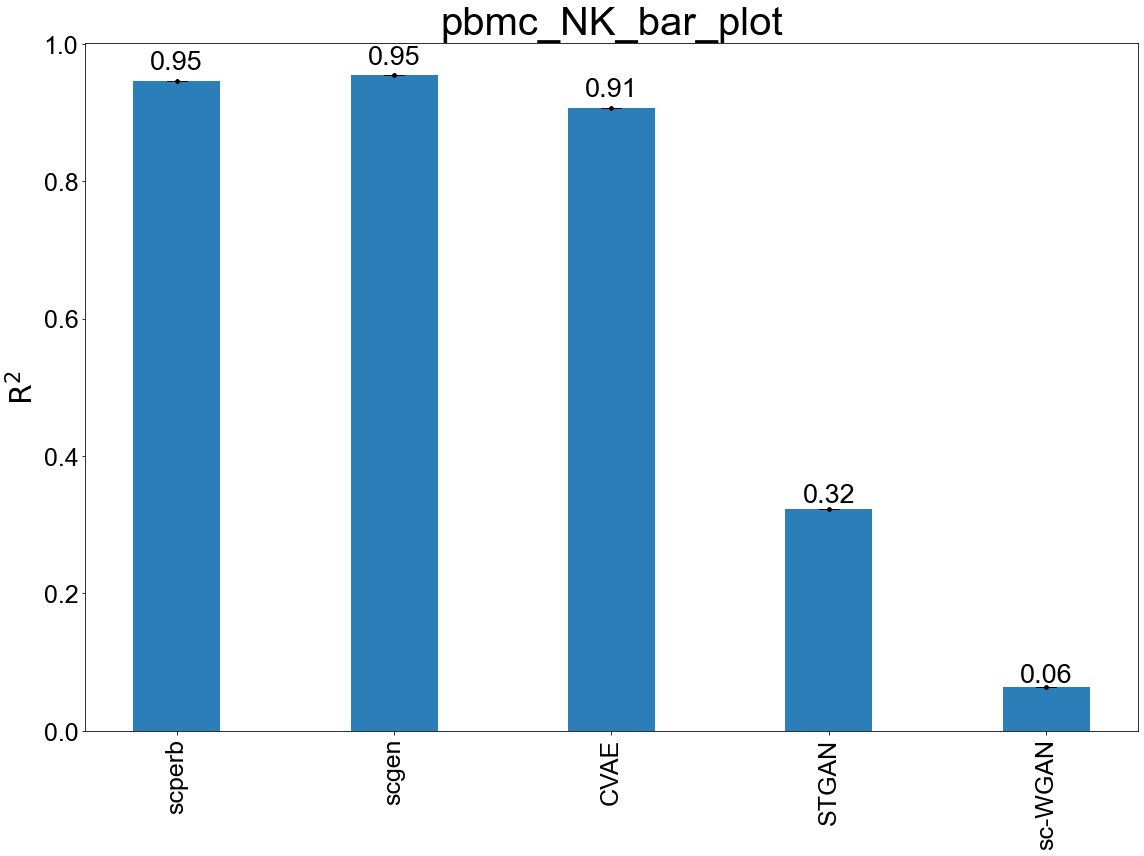

saved at:figures/grouped_boxplot/pbmc_all_models_all_celltype_barplots.pdf


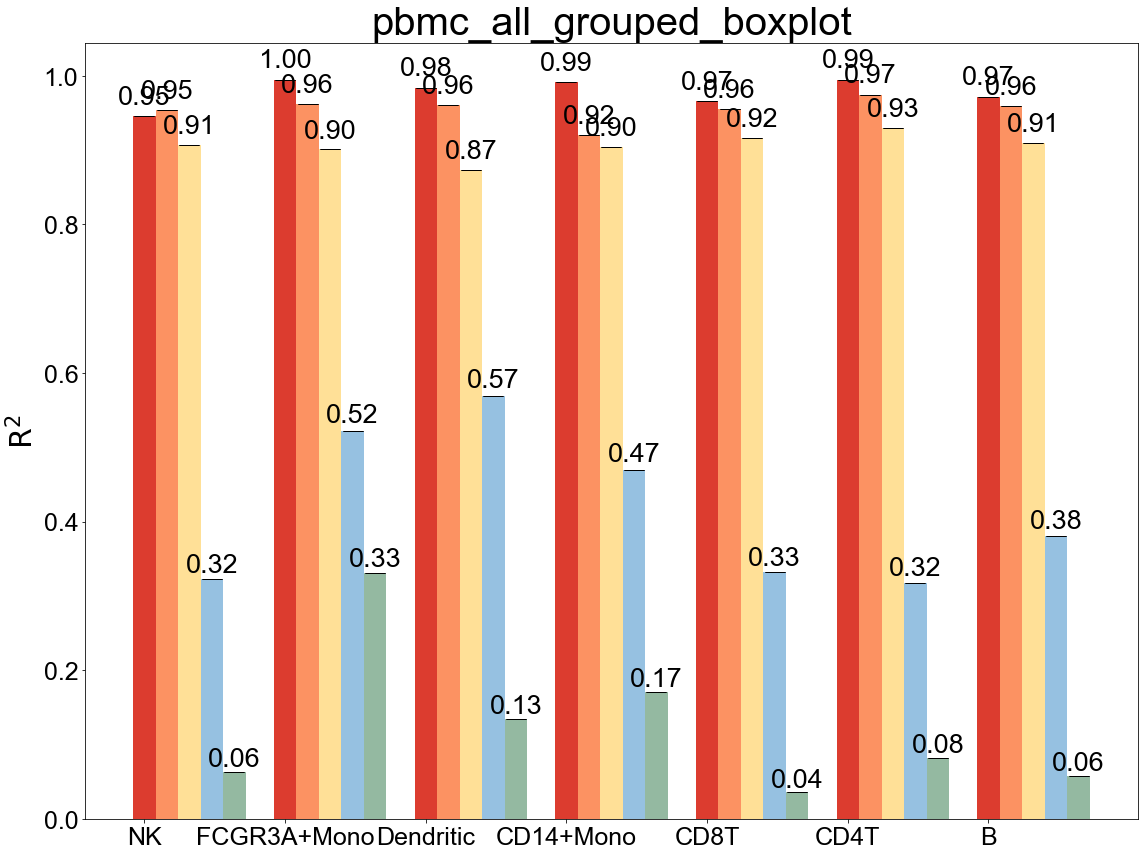

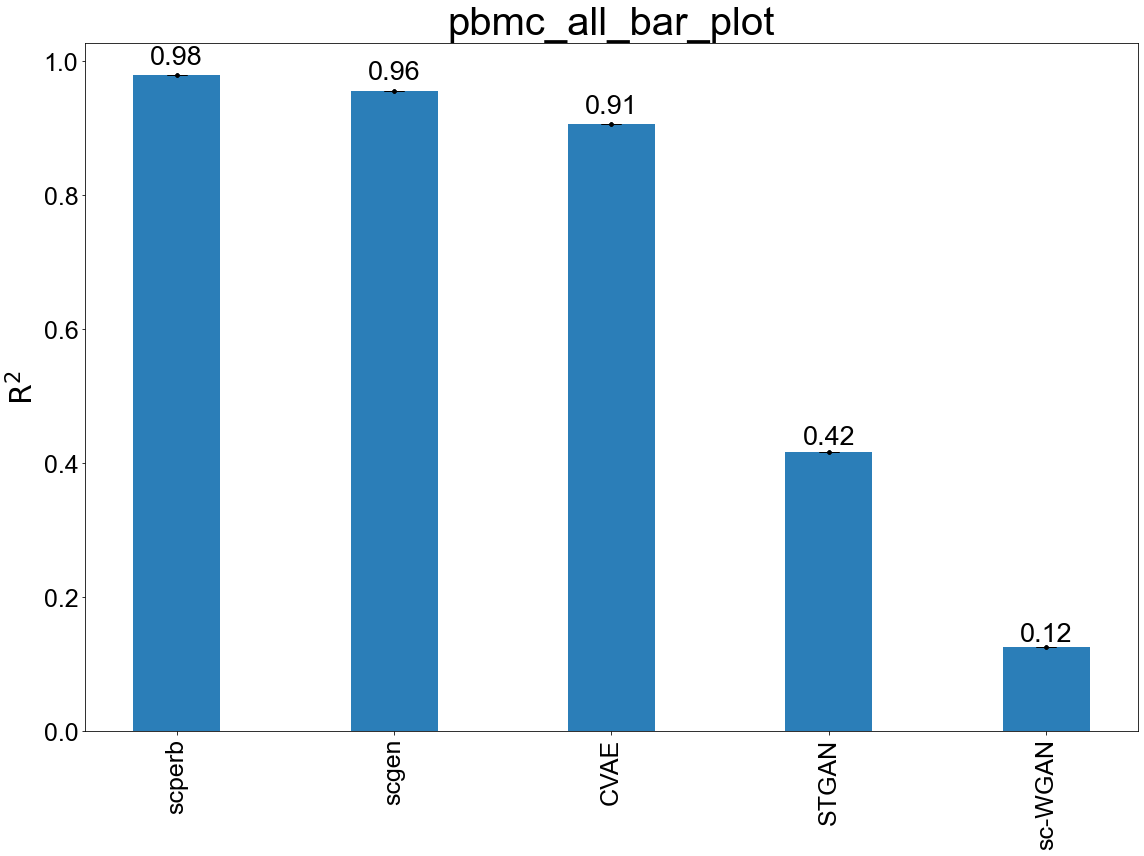

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

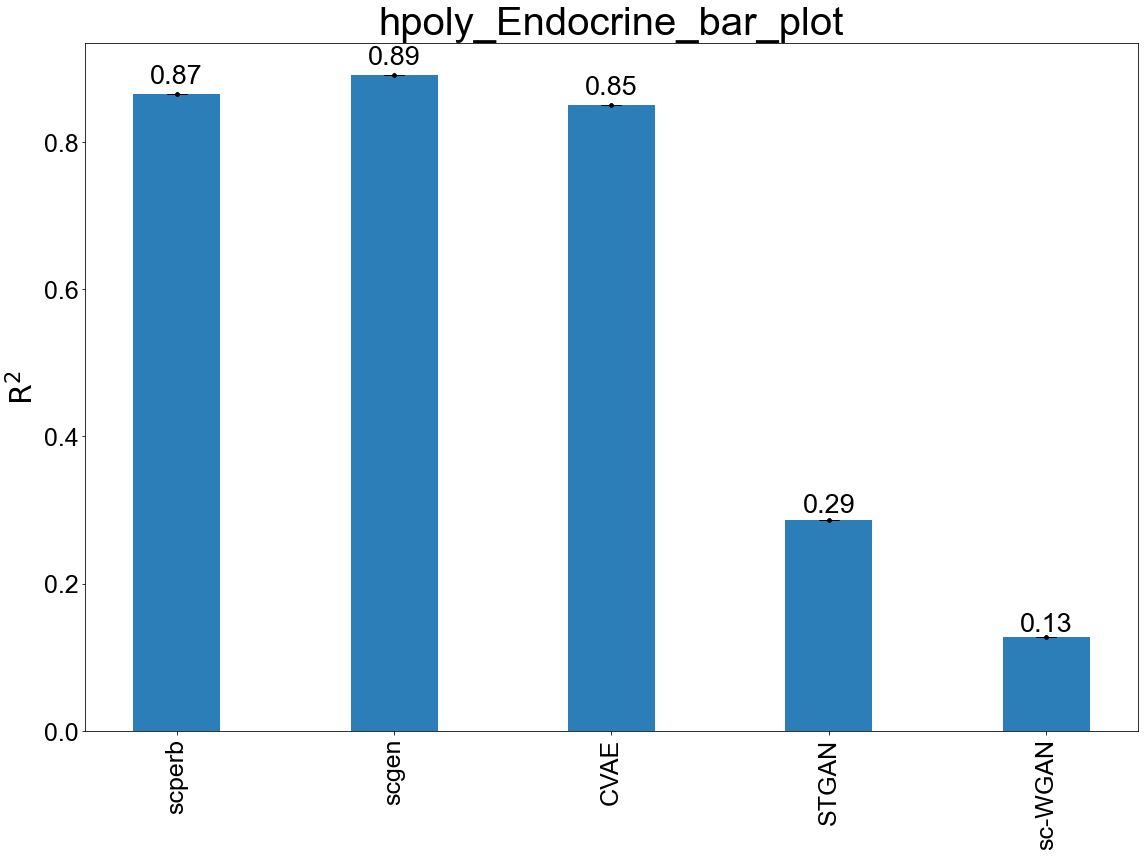

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

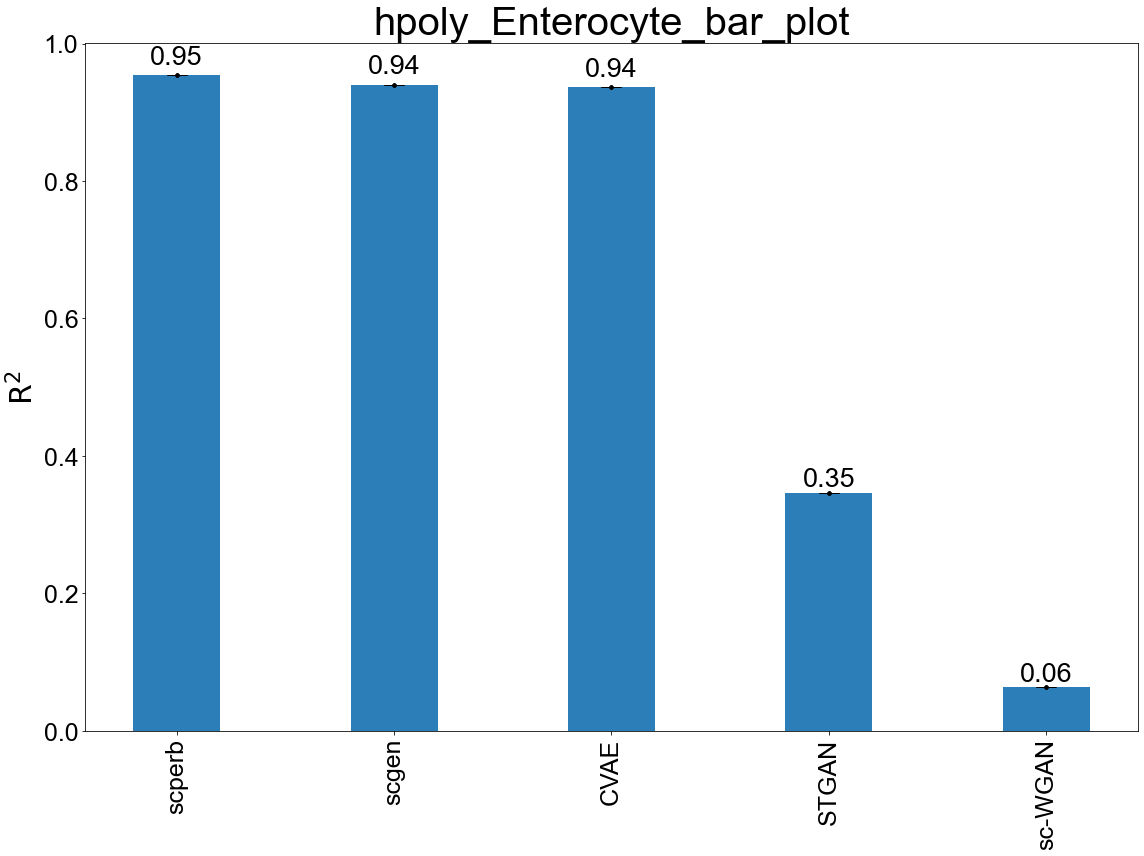

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

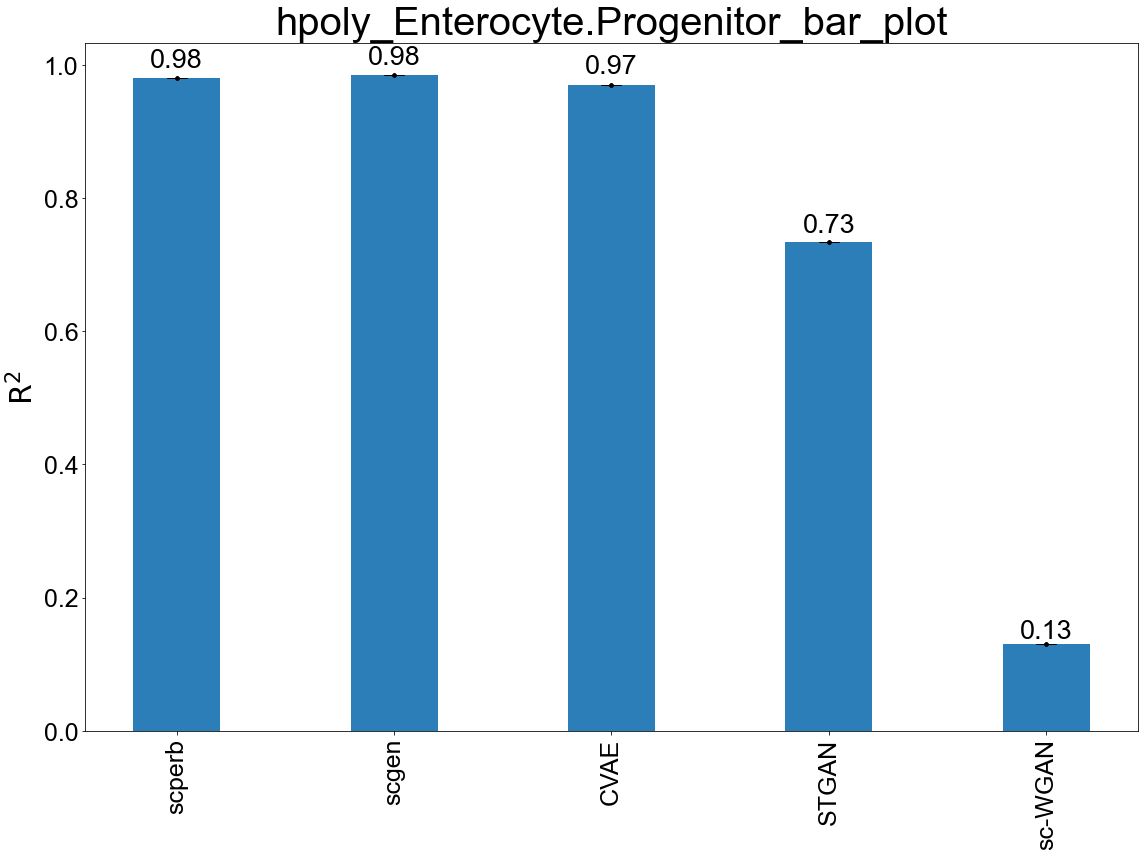

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

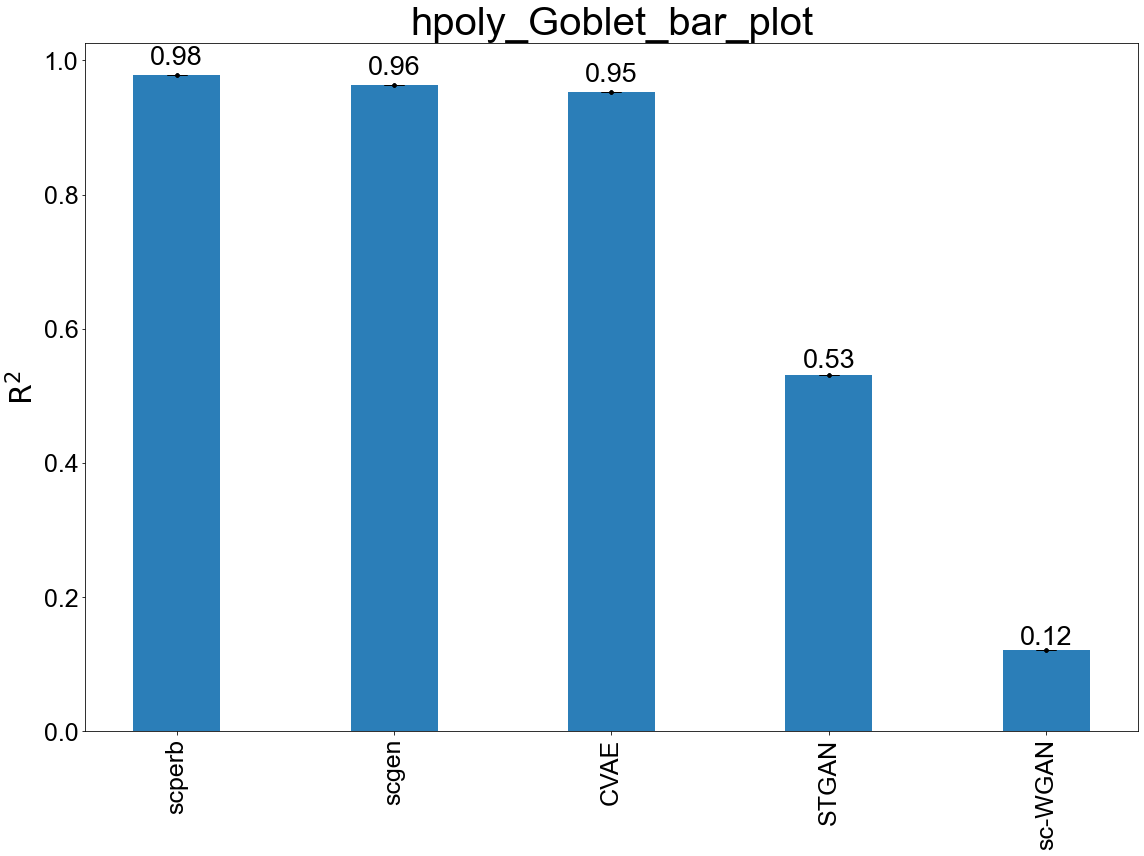

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

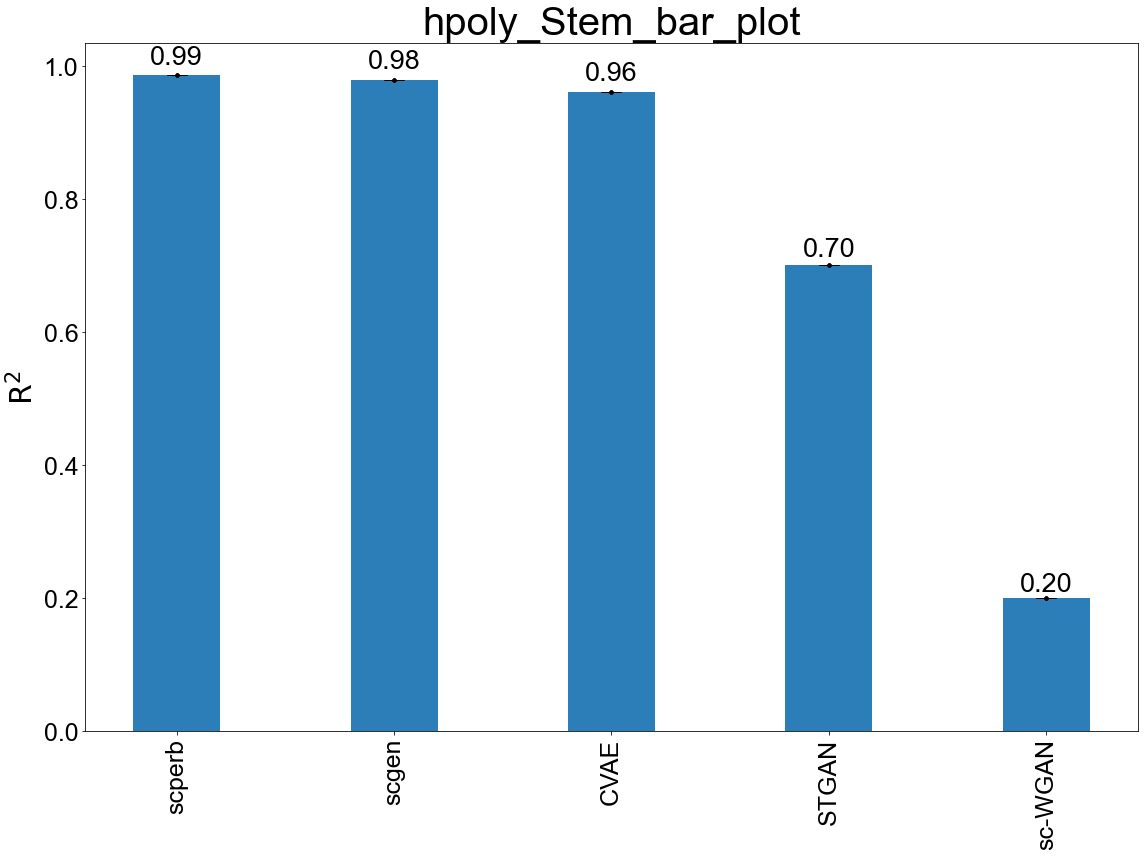

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

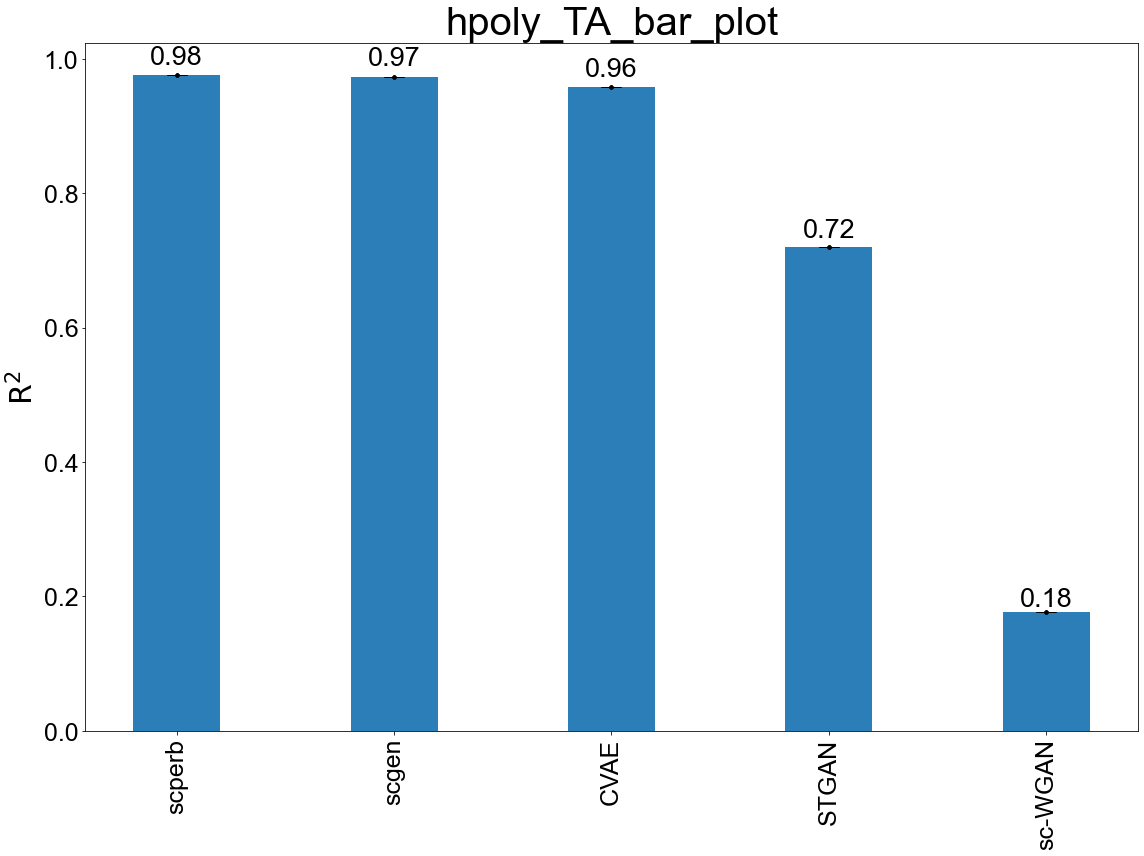

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

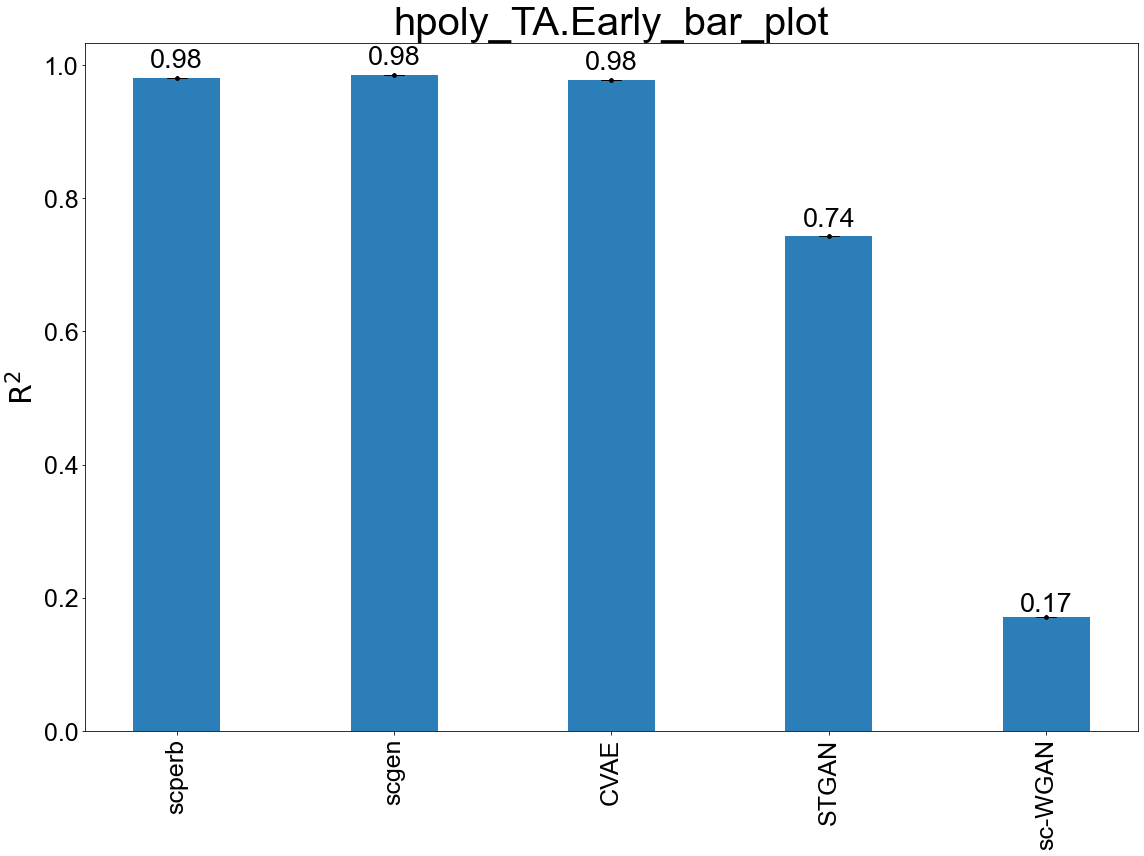

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid val

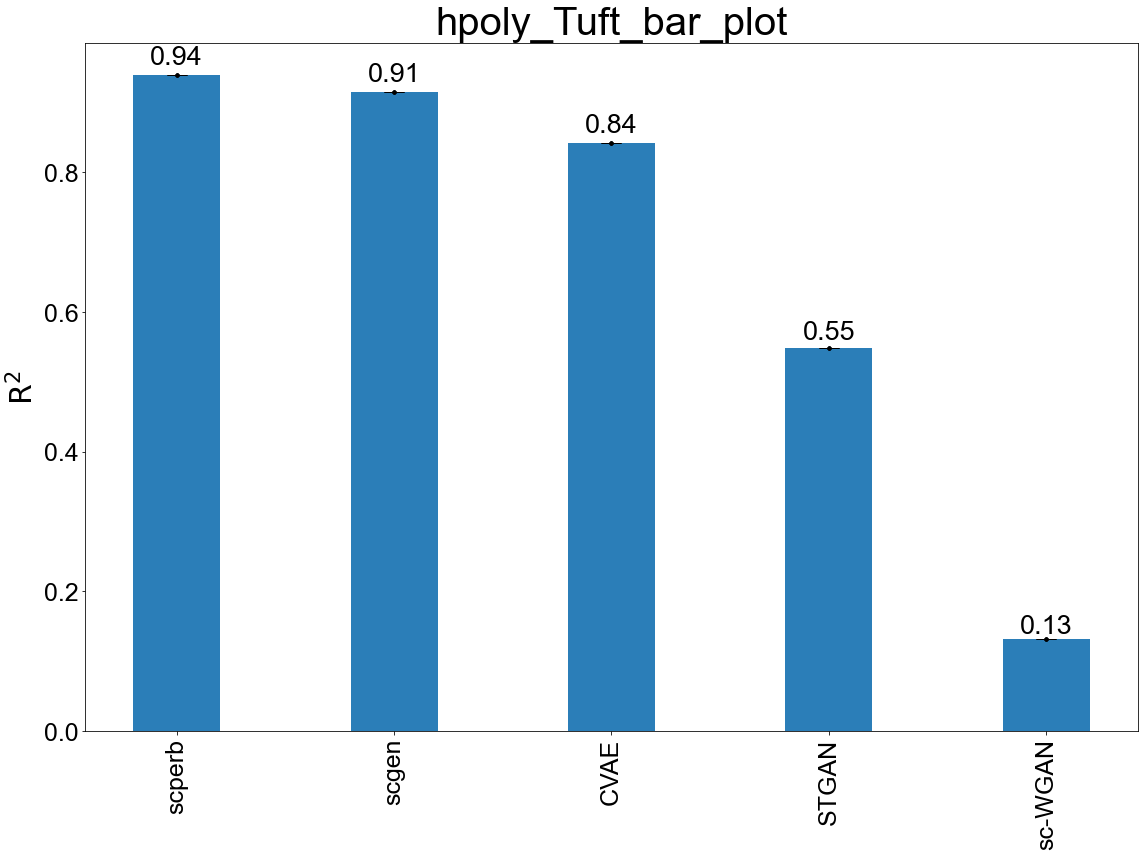

saved at:figures/grouped_boxplot/hpoly_all_models_all_celltype_barplots.pdf


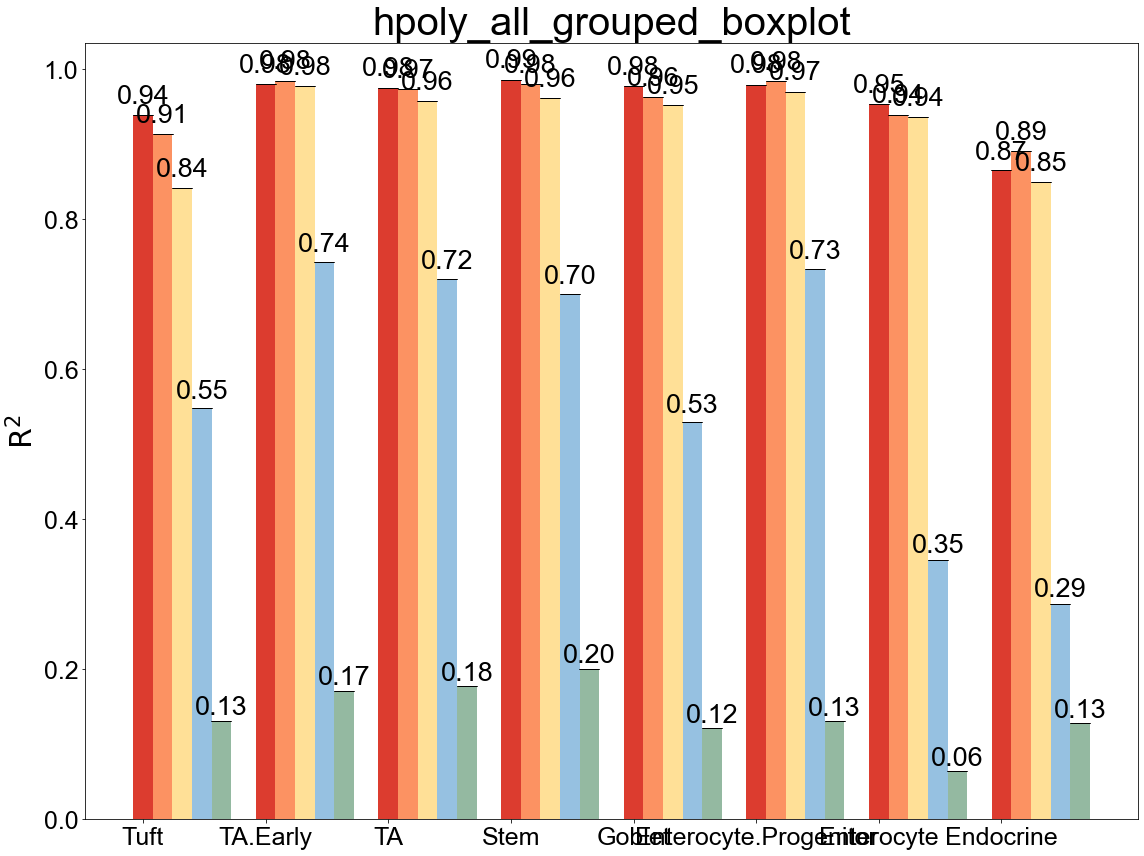

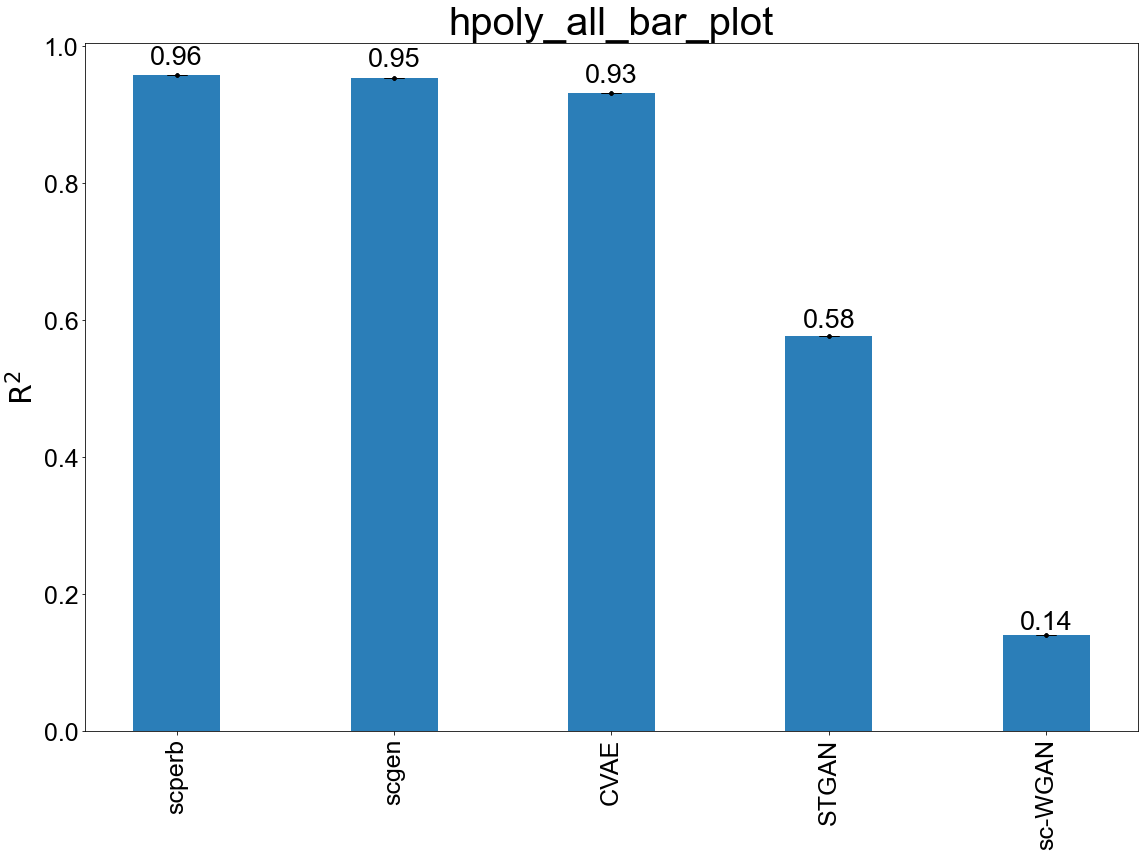

In [16]:
df_all_datasets_study, df_all_data_study = plot_all_cell_type_bar_garph("study")
df_all_datasets_pbmc, df_all_data_pbmc = plot_all_cell_type_bar_garph("pbmc")
df_all_datasets_hpoly, df_all_data_hpoly = plot_all_cell_type_bar_garph("hpoly")

saved at:figures/grouped_boxplot/all_models_barplots.pdf


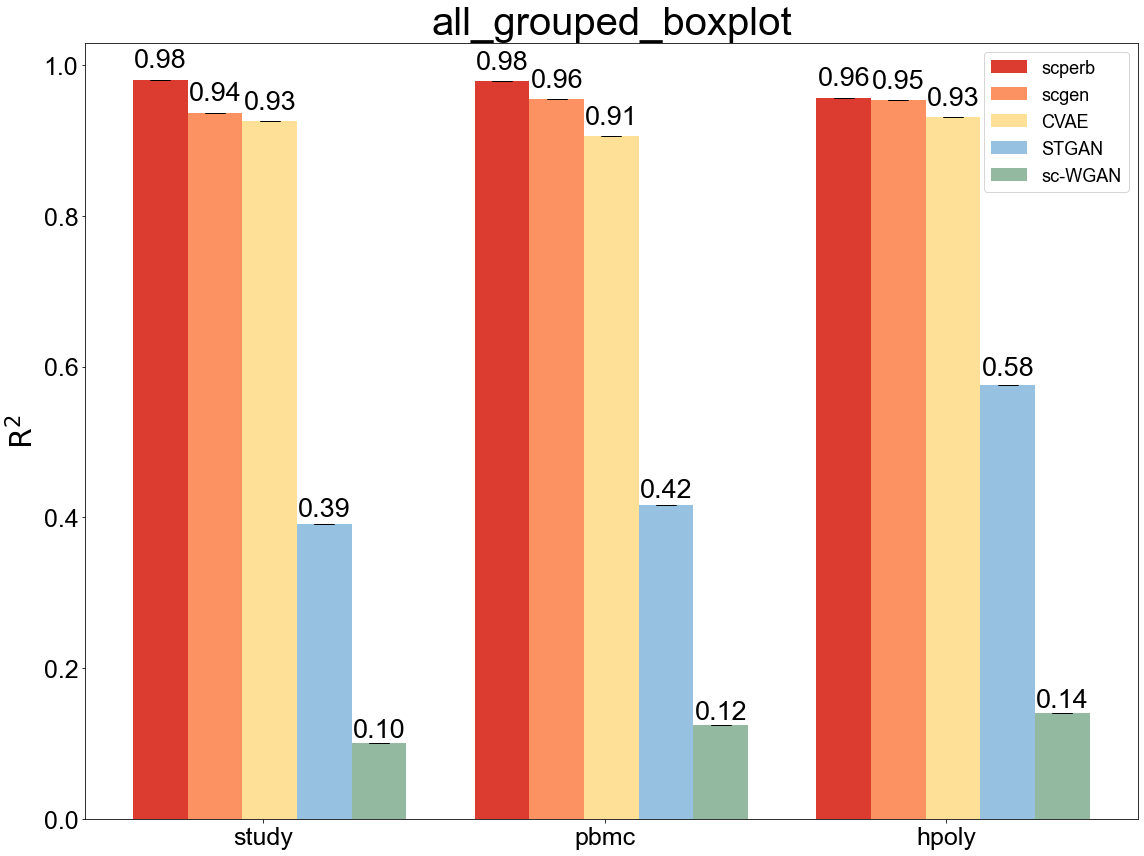

   R^2 Means  R^2 Stddevs       Type   Models cell dataset
0   0.981079          0.0  All genes   scperb  all   study
1   0.936990          0.0  All genes    scgen  all   study
2   0.925787          0.0  All genes     CVAE  all   study
3   0.391417          0.0  All genes    STGAN  all   study
4   0.100053          0.0  All genes  sc-WGAN  all   study
0   0.978499          0.0  All genes   scperb  all    pbmc
1   0.955174          0.0  All genes    scgen  all    pbmc
2   0.905818          0.0  All genes     CVAE  all    pbmc
3   0.416328          0.0  All genes    STGAN  all    pbmc
4   0.124797          0.0  All genes  sc-WGAN  all    pbmc
0   0.957180          0.0  All genes   scperb  all   hpoly
1   0.953784          0.0  All genes    scgen  all   hpoly
2   0.930893          0.0  All genes     CVAE  all   hpoly
3   0.576259          0.0  All genes    STGAN  all   hpoly
4   0.140219          0.0  All genes  sc-WGAN  all   hpoly


In [17]:
df_all_datasets = pd.concat([df_all_datasets_study, df_all_datasets_pbmc, df_all_datasets_hpoly])
grouped_allcelltype_barplot(df_all_datasets, 'dataset', 'Models', 'R^2 Means', 'R^2 Stddevs', put_label=True, legend=True, filename=f"all_models_barplots.pdf", offset=1.5, data_name="all", length = 17.5)
print(df_all_datasets)

saved at:figures/grouped_boxplot/all_models_barplots_for_ppt.pdf


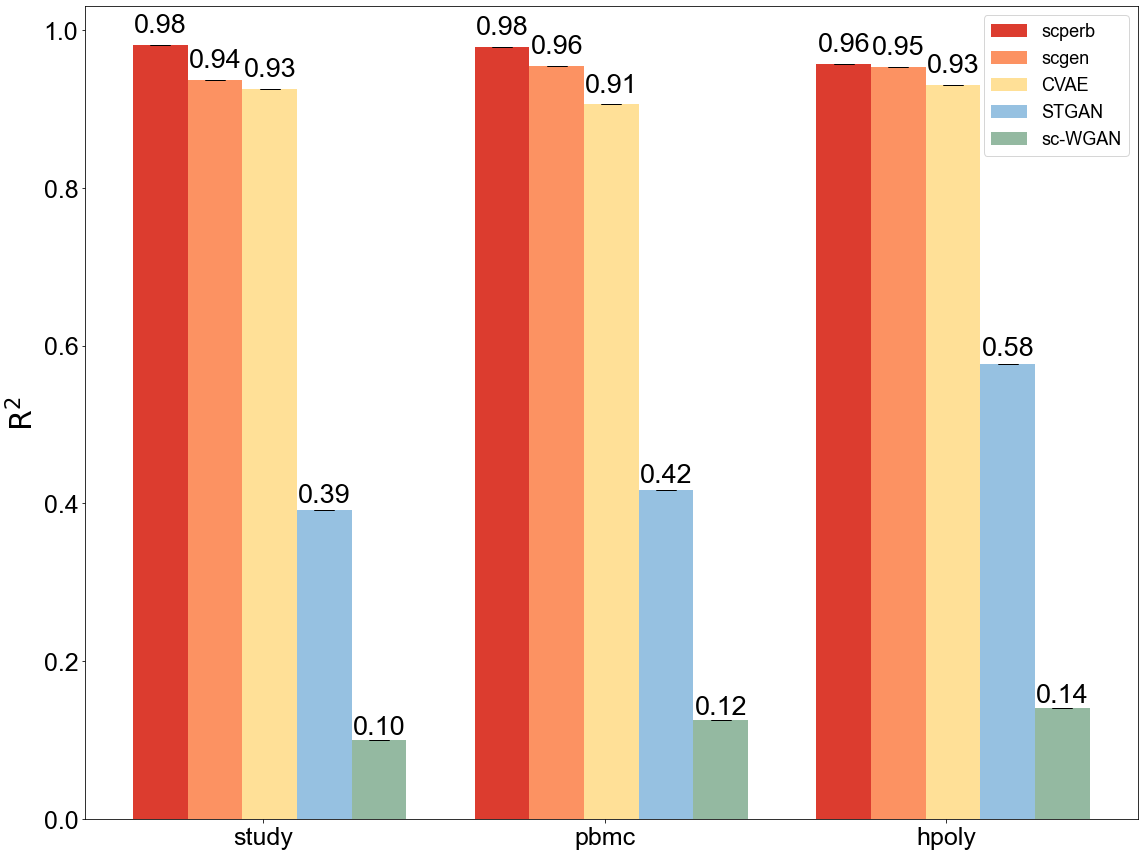

   R^2 Means  R^2 Stddevs       Type   Models cell dataset
0   0.981079          0.0  All genes   scperb  all   study
1   0.936990          0.0  All genes    scgen  all   study
2   0.925787          0.0  All genes     CVAE  all   study
3   0.391417          0.0  All genes    STGAN  all   study
4   0.100053          0.0  All genes  sc-WGAN  all   study
0   0.978499          0.0  All genes   scperb  all    pbmc
1   0.955174          0.0  All genes    scgen  all    pbmc
2   0.905818          0.0  All genes     CVAE  all    pbmc
3   0.416328          0.0  All genes    STGAN  all    pbmc
4   0.124797          0.0  All genes  sc-WGAN  all    pbmc
0   0.957180          0.0  All genes   scperb  all   hpoly
1   0.953784          0.0  All genes    scgen  all   hpoly
2   0.930893          0.0  All genes     CVAE  all   hpoly
3   0.576259          0.0  All genes    STGAN  all   hpoly
4   0.140219          0.0  All genes  sc-WGAN  all   hpoly


In [18]:
df_all_datasets = pd.concat([df_all_datasets_study, df_all_datasets_pbmc, df_all_datasets_hpoly])
grouped_allcelltype_barplot(df_all_datasets, 'dataset', 'Models', 'R^2 Means', 'R^2 Stddevs', put_label=True, legend=True, filename=f"all_models_barplots_for_ppt.pdf", offset=1.5, data_name="all", length = 17.5, ppt = True)
print(df_all_datasets)

In [19]:
def plot_line(df):
    matplotlib.rc('ytick', labelsize=30)
    matplotlib.rc('xtick', labelsize=25)
    colors = ['#DB3124', '#FC8C5A', '#FFDF92', '#90BEE0', '#8EB69C']
    models = ['scperb', 'scgen', 'CVAE', 'STGAN', 'sc-WGAN']
    datasets = ['pbmc', 'study', 'hpoly']
    for dataset in datasets:
        df_dataset = df[df['dataset'] == dataset]
        fig, ax = plt.subplots(figsize=(16,12))
        for idx, model in enumerate(models):
            df_model = df_dataset[df_dataset['Models'] == model]
            ax.plot(df_model.cell,
             df_model["R^2 Means"],
             linestyle = '-',
             linewidth = 2,
             color = colors[idx],
             marker = 'o',
             markersize = 10,
             markeredgecolor= colors[idx],
             markerfacecolor= colors[idx],
             label = f"{model}")
        ax.set_facecolor('white')
        ax.axis(True)
        ax.grid(False)
        ax.spines["left"].set_color("k")
        ax.spines["top"].set_color("k")
        ax.spines["bottom"].set_color("k")
        ax.spines["right"].set_color("k")
#         ax.annotate("", xy=(1.05, 0), xycoords='axes fraction', xytext=(-0.01, 0), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
#         ax.annotate("", xy=(0, 1.05), xycoords='axes fraction', xytext=(0, -0.01), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
        ax.set_title(f"{dataset}_all_model")
        ax.set_xlabel(f"cell_type", fontsize = 20)
        ax.set_ylabel(r"$\mathrm{R^2}$", fontsize = 30)
        fig.autofmt_xdate(rotation = 90)
        ax.legend(loc = 'best')
        plt.savefig(f"figures/line_plot/{dataset}_all_model_lineplot.pdf", transparent = True)
        plt.show()

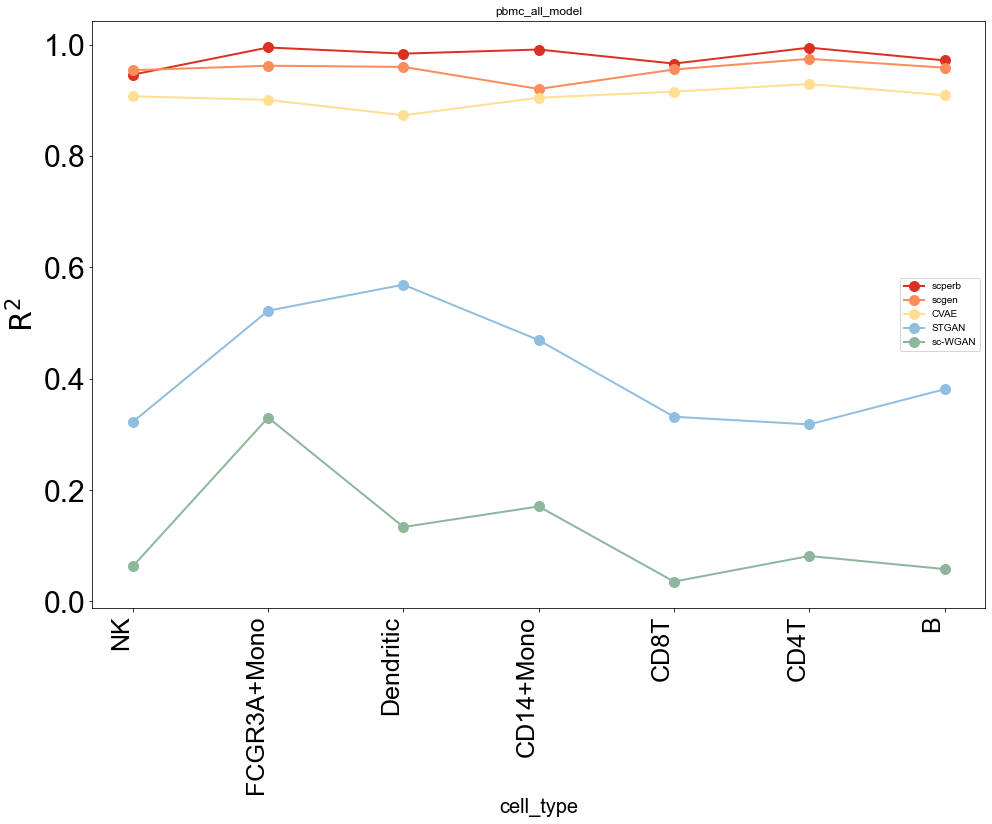

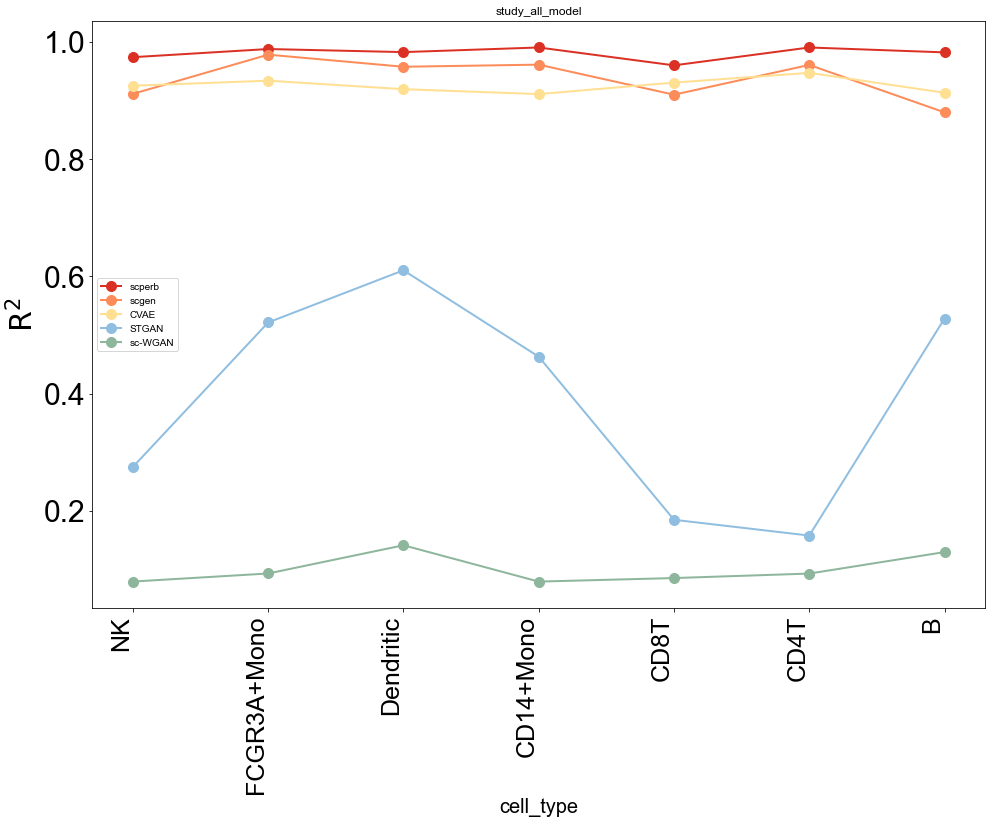

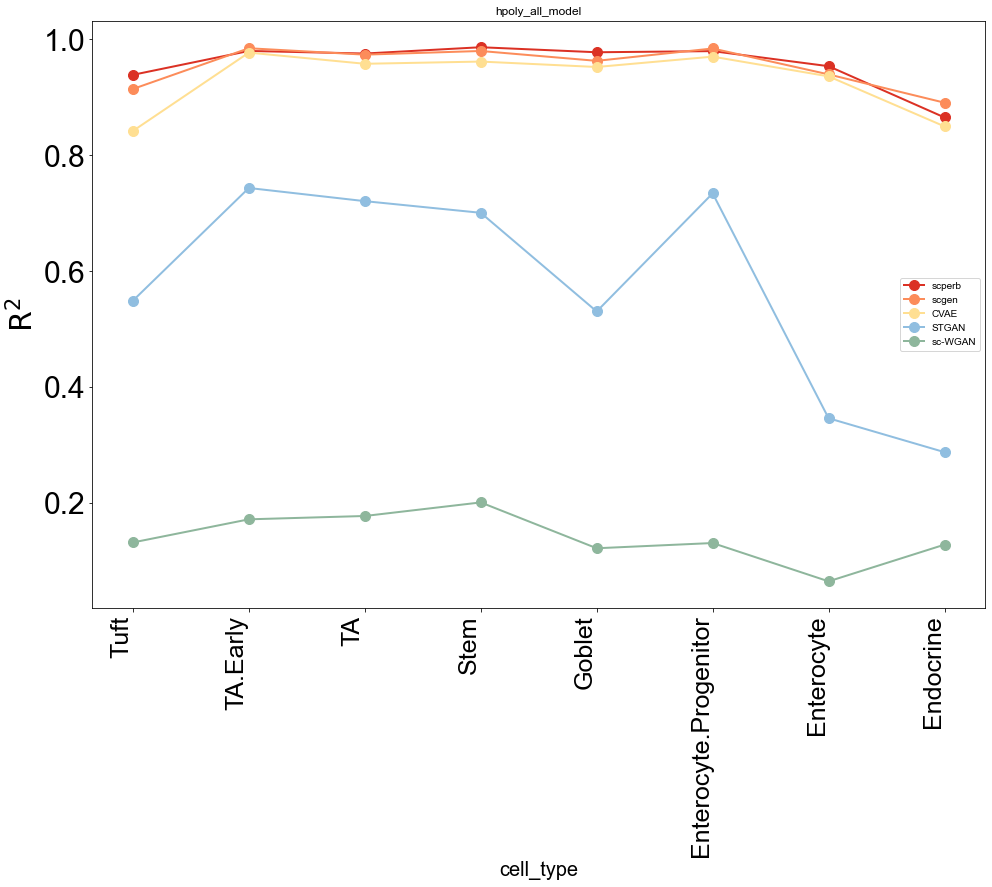

In [20]:
df_all_data = pd.concat([df_all_data_pbmc, df_all_data_hpoly, df_all_data_study])
plot_line(df_all_data)

In [21]:
def extract_cell_type_data(adata, cell_type, cell_type_key = 'cell_type'):
        return adata[adata.obs[cell_type_key] == cell_type] 

In [22]:
def get_condition_data(adata, condition_key = 'stimulated'):
        return adata[adata.obs['condition'] == condition_key] 

In [23]:
def get_genes(adata, stim_name = 'stimulated'):
    sc.tl.rank_genes_groups(adata, groupby="condition", method="wilcoxon")
    diff_genes = adata.uns["rank_genes_groups"]["names"][stim_name]
    return diff_genes

In [24]:
def create_df(adata, data_name, stim_data):
    adata_test = adata.concatenate(stim_data)
    sc.tl.rank_genes_groups(adata_test, groupby="condition", method="wilcoxon")
    adata_names = np.array(adata_test.uns["rank_genes_groups"]['names'].tolist())
    adata_pval = np.array(adata_test.uns["rank_genes_groups"]['pvals_adj'].tolist())
    ind = []
    for name in adata_names:
        ind.append(name[0])
    pval = []
    for pv in adata_pval:
        pval.append(pv[0])
    
    df = pd.DataFrame(index=ind)
    df[data_name + "_Pval"] = pval
    
    return df

In [25]:
def get_df(cell_type, name):
    all_data = get_cell_type_data(cell_type, name)
    scperb_df = create_df(get_condition_data(all_data, 'scperb'), "scperb", get_condition_data(all_data, 'real'))
    scgen_df = create_df(get_condition_data(all_data, 'scgen'), "scgen", get_condition_data(all_data, 'real'))
    cvae_df = create_df(get_condition_data(all_data, 'CVAE'), 'CVAE', get_condition_data(all_data, 'real'))
    stgan_df = create_df(get_condition_data(all_data, 'STGAN'), 'STGAN', get_condition_data(all_data, 'real'))
    wgan_df = create_df(get_condition_data(all_data, 'sc-WGAN'), 'sc-WGAN', get_condition_data(all_data, 'real'))
    all_df = scperb_df.join([scgen_df, cvae_df, stgan_df, wgan_df], how = 'left')
    return all_df

In [26]:
CD4T_pbmc_df = get_df("CD4T", "pbmc")
Goblet_df = get_df("Goblet", "hpoly")
CD4T_study_df = get_df("CD4T", "study")
CD4T_pbmc_df.to_csv()
print(CD4T_pbmc_df)
print(Goblet_df)
print(CD4T_study_df)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  WGAN_pred.obs['condition'] = "sc-WGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ctrl.obs['condition'] = "control"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:15: ImplicitModificationWarning: Tr

                scperb_Pval     scgen_Pval     CVAE_Pval    STGAN_Pval  \
IRF7           2.549128e-06   1.536594e-05  1.817883e-07  2.814858e-30   
IFIT2          1.006640e-05   7.109822e-02  4.336508e-22  2.863857e-28   
GIMAP5         7.677658e-04   1.522224e-04  4.587165e-05  7.170654e-09   
CCR7           2.581494e-03   8.062478e-07  7.096507e-14  8.877084e-34   
SOD1           6.220584e-03   1.265692e-01  1.000000e+00  7.259760e-05   
...                     ...            ...           ...           ...   
AC022182.1    4.631252e-102   3.559588e-18  1.000000e+00  1.000000e+00   
C8orf44-SGK3  4.631252e-102   1.911564e-55  1.000000e+00  1.000000e+00   
XKR9          4.631252e-102   8.933041e-02  1.000000e+00  1.000000e+00   
HEY1          4.631252e-102   1.948637e-35  1.000000e+00  1.000000e+00   
RP4-798A10.7  4.631252e-102  7.280468e-100  1.000000e+00  1.000000e+00   

               sc-WGAN_Pval  
IRF7           5.303032e-10  
IFIT2          4.616008e-60  
GIMAP5         4.7301

/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/tongtongtot/opt/anaconda3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [27]:
def plot_violin(use_gene, color_map, cell_type, name):
    models_violin = get_cell_type_data(cell_type, name)
    new_models = models_violin
    var_temp = models_violin.var_names.tolist()
    var_temp[var_temp.index(use_gene)] = use_gene + f" in {cell_type}"
    new_models.var_names = var_temp
    font = {'family' : 'Arial',
        'size'   : 30}

    sc.set_figure_params(fontsize=25)
    sns.set()
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('xtick', labelsize=14)
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_facecolor('white')
    ax.axis(True)
    ax.grid(False)
    ax.spines["left"].set_color("k")
    ax.spines["top"].set_color("k")
    ax.spines["bottom"].set_color("k")
    ax.spines["right"].set_color("k")
    sc.pl.violin(new_models, 
                 keys= use_gene + f" in {cell_type}", 
                 groupby="condition", 
                 show=True,
                 rotation = 90,
                 order=new_models.obs["condition"].unique().tolist(),
                 palette = color_map,
                 save= f"_model/{name}_{cell_type}_{use_gene}_violin_plot.pdf",
                 title = f"{name}_{cell_type}_{use_gene}_violin_plot",
                 ax = ax,
                )

In [28]:
def plot_Pval_adj(df, gene_name, name):
    plt.bar(df.loc[gene_name])

    # Adding labels with real numbers on top of the bars
    for index, row in df.iterrows():
        plt.text(row.name, row['Value'] + 0.5, str(row['Value']), ha='center')

    # Adding labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Bar Graph with Value Labels')

    # Display the plot
    plt.show()

In [29]:
def get_all_violin_plot(data_name, gene_names, cell_type_name, df):
#     df = df.round(10)
    for gene_name in gene_names[data_name]:    
        plot_violin(gene_name, color_map, cell_type_name, data_name)
        print(gene_name)
        names = df.loc[gene_name]
#         names.plot.bar()
#         plot_Pval_adj(df, gene_name, f"figures/csvs/{data_name}_{gene_name}_Pval")
        names.to_csv(f"figures/csvs/{data_name}_{gene_name}_Pval.csv")
#         names.round(4)
        print(names)
#         print(type(names))
#         for name, val in names:
#             print(f"{name}:   ", val)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

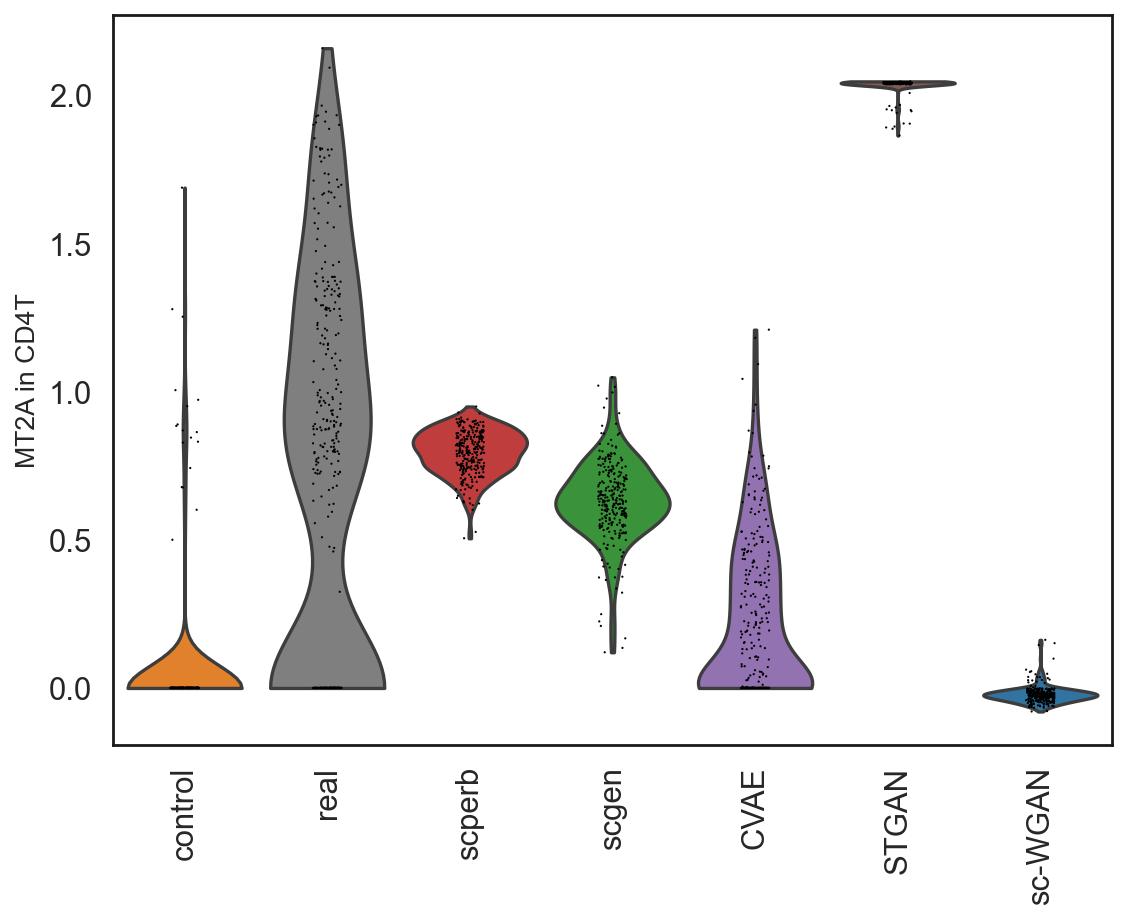

MT2A
scperb_Pval     8.785023e-01
scgen_Pval      5.808311e-04
CVAE_Pval       6.070734e-14
STGAN_Pval      2.502235e-99
sc-WGAN_Pval    2.414616e-91
Name: MT2A, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

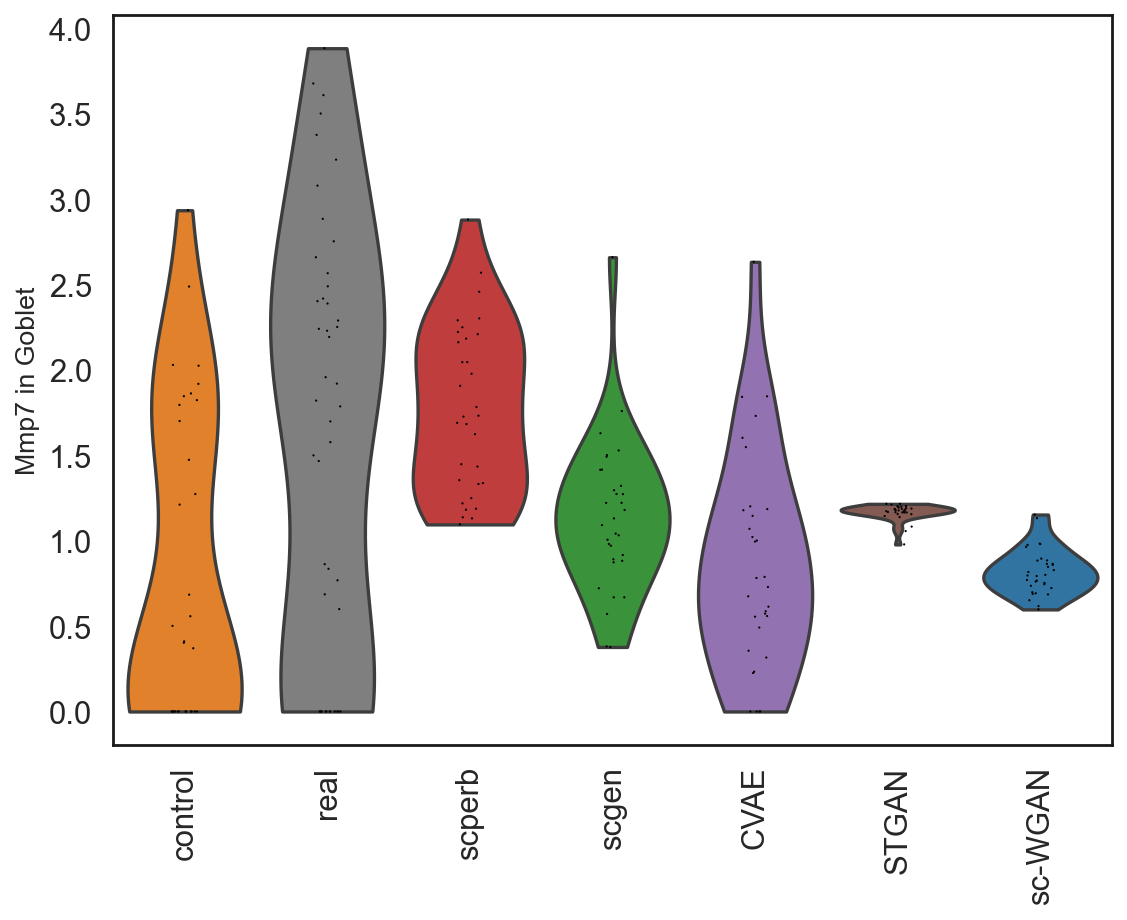

Mmp7
scperb_Pval     1.000000
scgen_Pval      0.095023
CVAE_Pval       0.485654
STGAN_Pval      0.145942
sc-WGAN_Pval    0.016358
Name: Mmp7, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

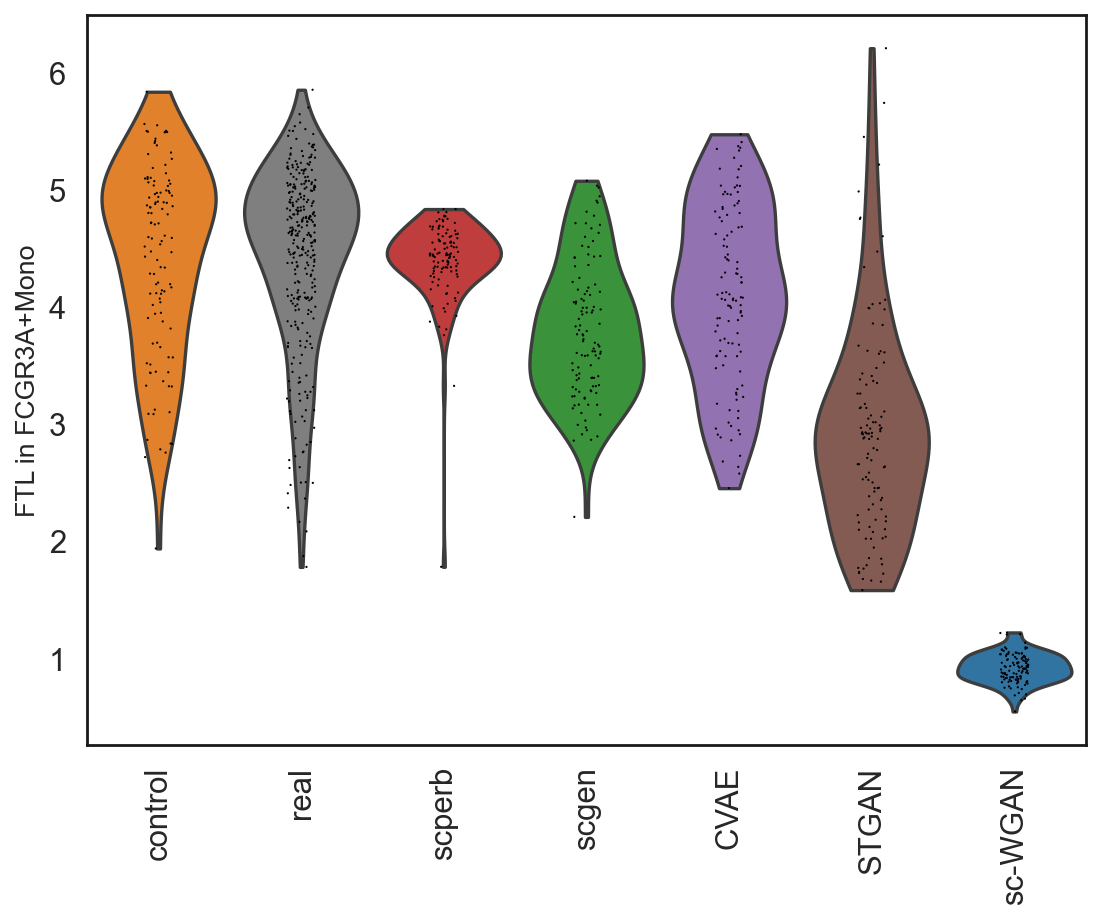

FTL
scperb_Pval      1.763158e-01
scgen_Pval       6.298732e-15
CVAE_Pval        3.075879e-02
STGAN_Pval      4.805420e-109
sc-WGAN_Pval     2.013252e-31
Name: FTL, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

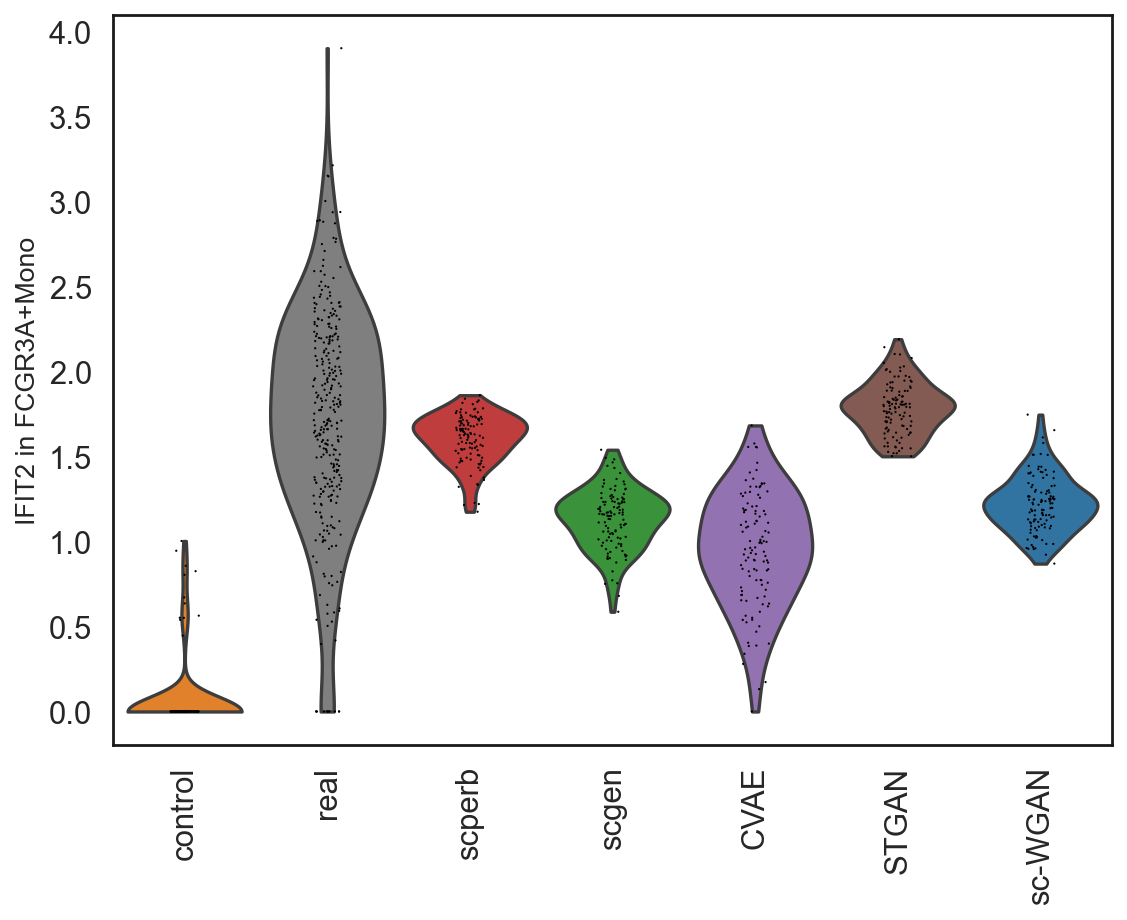

IFIT2
scperb_Pval      7.428659e-02
scgen_Pval       3.328290e-03
CVAE_Pval        1.634601e-09
STGAN_Pval      3.137386e-103
sc-WGAN_Pval     2.408305e-10
Name: IFIT2, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_57593/259588096.py:13: ImplicitModificationWarning

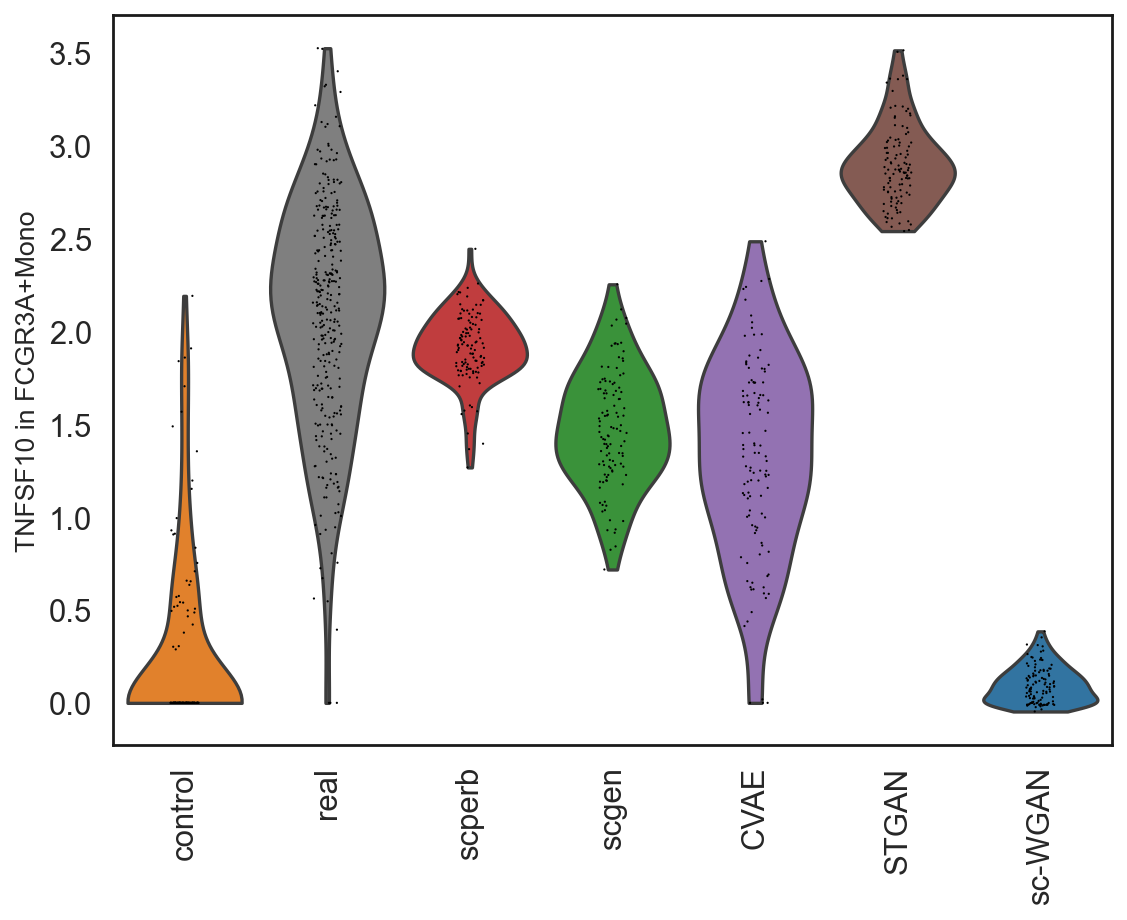

TNFSF10
scperb_Pval      1.473847e-01
scgen_Pval       5.959890e-06
CVAE_Pval        5.917595e-20
STGAN_Pval      6.696160e-108
sc-WGAN_Pval     1.292805e-03
Name: TNFSF10, dtype: float64


In [30]:
# names = ['MT2A', 'S100A11', 'CD3D', 'BTG1', 'UBC', 'PFN1', 'SP100', 'IFIT1']
#colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
color_map = {'sc-WGAN': "#1f77b4", 'scperb': '#D62728', 'control': '#ff7f0e', 'scgen': '#2ca02c', 'CVAE': '#9467bd', 'STGAN': '#8c564b', 'real': '#7f7f7f'}
gene_names = {
    "pbmc" : ['MT2A'],
    "hpoly" : ['Mmp7'],
    "study" : ['FTL', 'IFIT2','TNFSF10'],
}
get_all_violin_plot("pbmc", gene_names, "CD4T", CD4T_pbmc_df)
get_all_violin_plot("hpoly", gene_names, "Goblet", Goblet_df)
get_all_violin_plot("study", gene_names, "FCGR3A+Mono", CD4T_study_df)